<img align='left' style='height:100px; width:100px;' src="https://resources.cdn.seon.io/uploads/2022/04/5-types-of-bank-account-fraud_isolated.png"><h1 style='color:red;'>&nbsp;&nbsp;<u>Bank Account Fraud Detection Case Study</u></h1> 

# Imports and Visualization

<h3>Import Libraries</h3>

In [1]:
import os
import numpy as np,seaborn as sns,pandas as pd,matplotlib.pyplot as plt,warnings
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score,classification_report,  accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from aequitas.group import Group
warnings.filterwarnings("ignore")

/home/bernardo/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


<h3>Read CSV</h3>

In [2]:
def load_test_csv(file):
    return pd.read_csv(file, dtype= {
    'id': np.int64,
    'income': np.float64,
    'name_email_similarity': np.float64,
    'prev_address_months_count': np.float64,
    'current_address_months_count': np.float64,
    'customer_age': np.float64,
    'days_since_request': np.float64,
    'intended_balcon_amount': np.float64,
    'payment_type': object,
    'zip_count_4w': np.float64,
    'velocity_6h': np.float64,
    'velocity_24h': np.float64,
    'velocity_4w': np.float64,
    'bank_branch_count_8w': np.float64,
    'date_of_birth_distinct_emails_4w': np.float64,
    'employment_status': object,
    'credit_risk_score': np.float64,
    'email_is_free': np.float64, # binary
    'housing_status': object,
    'phone_home_valid': np.float64, # binary
    'phone_mobile_valid': np.float64, # binary
    'bank_months_count': np.float64,
    'has_other_cards': np.float64, # binary
    'proposed_credit_limit': np.float64,
    'foreign_request': np.float64, # binary
    'source': object,
    'session_length_in_minutes': np.float64,
    'device_os': object,
    'keep_alive_session': np.float64, # binary
    'device_distinct_emails_8w': np.float64,
    'device_fraud_count': np.float64,
    'month': np.float64,
    'credit_utilization_ratio': np.float64,
    'distance_to_nearest_bank_branch': np.float64,
    'recent_loan_approval_ratio': np.float64,
    'transaction_amount_ratio': np.float64,
})

df = load_test_csv('train.csv')

In [3]:
df.head()

,Unnamed: 0,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,credit_utilization_ratio,distance_to_nearest_bank_branch,recent_loan_approval_ratio,transaction_amount_ratio,fraud_bool
0,46366,0.5,0.373871,-1.0,121.0,30.0,0.003567,-0.472057,AC,658.0,...,other,1.0,1.0,0.0,7.0,0.5,0.764169,0.339598,0.543121,0
1,621359,0.9,0.825883,-1.0,49.0,50.0,0.030717,-1.061802,AB,640.0,...,windows,0.0,1.0,0.0,0.0,0.1,0.616470,0.498923,0.869324,1
2,43514,0.9,0.513736,55.0,5.0,50.0,0.027741,-0.544109,AB,1862.0,...,windows,1.0,1.0,0.0,7.0,0.1,0.302784,0.395494,0.891434,0
3,60994,0.9,0.489962,118.0,1.0,50.0,0.006615,-0.755948,AD,251.0,...,other,1.0,1.0,0.0,7.0,0.1,0.640823,0.488663,0.840134,0
4,66978,0.4,0.765966,-1.0,44.0,40.0,0.003371,-0.923310,AD,642.0,...,linux,1.0,1.0,0.0,7.0,0.6,0.373017,0.422912,0.340242,0


## Data Info 

We have 70000 records. Some of them with Nan values. We have 36 features and 1 target variable.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        70000 non-null  int64  
 1   income                            69928 non-null  float64
 2   name_email_similarity             69926 non-null  float64
 3   prev_address_months_count         70000 non-null  float64
 4   current_address_months_count      70000 non-null  float64
 5   customer_age                      69937 non-null  float64
 6   days_since_request                70000 non-null  float64
 7   intended_balcon_amount            70000 non-null  float64
 8   payment_type                      69940 non-null  object 
 9   zip_count_4w                      70000 non-null  float64
 10  velocity_6h                       70000 non-null  float64
 11  velocity_24h                      70000 non-null  float64
 12  velo

In [5]:
def all_unique(df):
    return [(i, df[i].unique()) for i in df.columns]

for i,j in all_unique(df):
    print(i, j)


for column in df.columns:
    if df[column].dtype == 'float64' or df[column].dtype == 'int64':
        min_value = df[column].min()
        max_value = df[column].max()
        print(f'Column: {column}, Min: {min_value}, Max: {max_value}')
    else:
        print(f'Column: {column} is Categorical')
 

Unnamed: 0 [ 46366 621359  43514 ...  28475  11482 513057]
income [0.5 0.9 0.4 0.2 0.7 0.3 0.1 0.6 0.8 nan]
name_email_similarity [0.37387107 0.82588341 0.51373642 ... 0.89127634 0.69402929 0.18265925]
prev_address_months_count [ -1.  55. 118. 147. 144.  52. 106.  45. 293.  25.  24.  29.  22.  12.
  96.  34.  67.  50. 100.  61.  36. 181.  28.  32.  35. 108.  93. 315.
 149.  65. 110. 127.  89.  49. 103.  10. 148.  99.  54.  11.  69.  31.
  62.  86. 101.  42.   9. 197. 195.  30.  51.  90.  27.  33.  94. 107.
  60.  91.  57.  83.  88.  37.  13.  59.  18.  21.  48.  47. 318.  26.
 292.  97.  95.  19. 323.  66. 328.  64.  46. 105.  53.   8.  38. 320.
 111. 230. 338.  23. 155. 204. 146.  92.  63. 122. 185.  78.  98. 141.
 177.  58.  80. 245. 214. 166. 112. 104.  56. 337.  82.  40. 180.  43.
 176.  87.  44. 109. 306.  85. 179. 170. 120. 102. 298. 156.  41. 125.
 174.  20.  68.  71. 311.  79.  74. 113. 163. 150. 217. 133. 139. 165.
 114. 319. 117.  76. 182. 287.  72. 132. 307. 302. 143. 212.  

# Data Cleaning

After observing the data, we can see that there are some columns which are not useful for our analysis.
1. Column 'Unnamed: 0' is just the index of the data. So, we will drop this column.
2. Columns that have only one unique value. We will drop these columns as they are not useful for our analysis, like 'device_fraud_count'.
3. Column 'customer_age' has a lot of negative values. We will drop the rows that have negative values in this column.
4. The values of proposed_credit_limit must be between 200 and 2000. We will drop the rows that have values less than 200 and greater than 2000.

We need to clean the data before we can use it for our analysis. 
1. We will check what columns have missing values.
2. We will be searching for '-1' that is used as a placeholder for missing values.
2. We will check what percentage of data is missing in each column.
3. We will drop columns that have more than 60% missing values.
4. We will check if there are any duplicate rows in the data.




In [6]:
df.drop(['Unnamed: 0', 'device_fraud_count'],1,inplace=True)
df = df[(df['customer_age'] >= 10) & (df['customer_age'] <= 90)]
df = df[(df['proposed_credit_limit'] >= 200) & (df['proposed_credit_limit'] <= 2000)]
df = df[(df['transaction_amount_ratio'] >= 0) & (df['transaction_amount_ratio'] <= 1)]

In [7]:
columns_that_have_placeholders = ['prev_address_months_count','current_address_months_count','bank_months_count']
for i in columns_that_have_placeholders:
    df[i] = df[i].replace(-1, np.nan)

In [8]:
def is_number(obj):
    return isinstance(obj, (int, float, complex))

missing_props_train = df.isna().mean()
for i in missing_props_train[missing_props_train > 0.6].index:
    df.drop(i, axis=1, inplace=True) 
missing_props_train = df.isna().mean()    
for i in missing_props_train[missing_props_train > 0].index:
    if(is_number(df[i][0])):
        df[i] = df[i].fillna(df[i].median())  

In [9]:
df.duplicated().any()

False

# Data Distribution

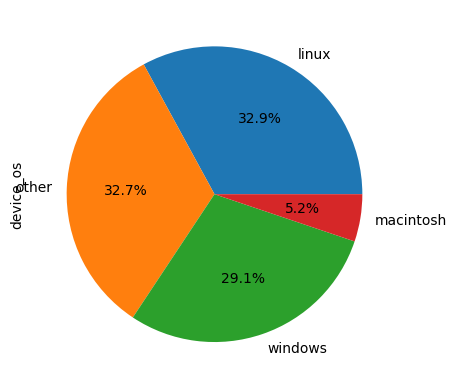

In [10]:
df['device_os']=df['device_os'].replace('x11','other')
df['device_os'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

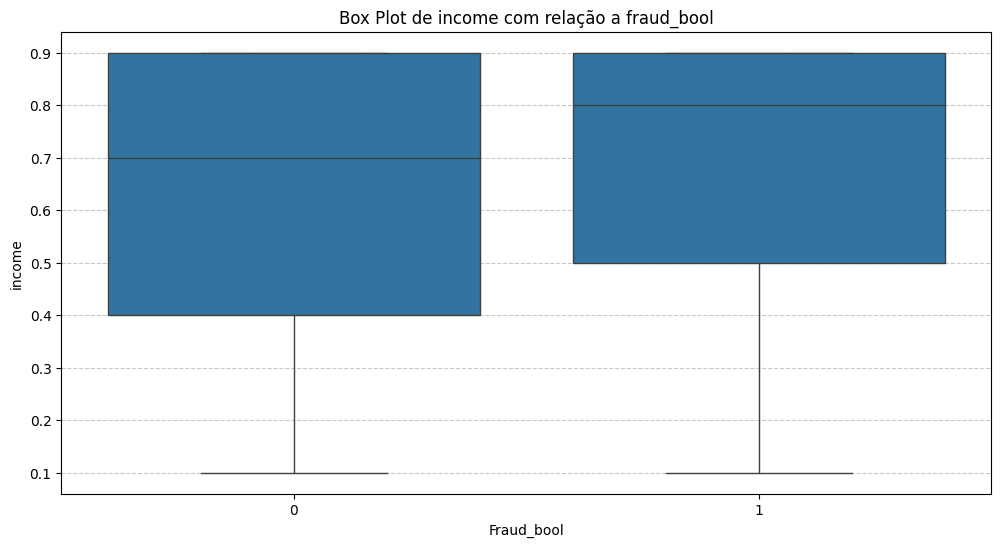

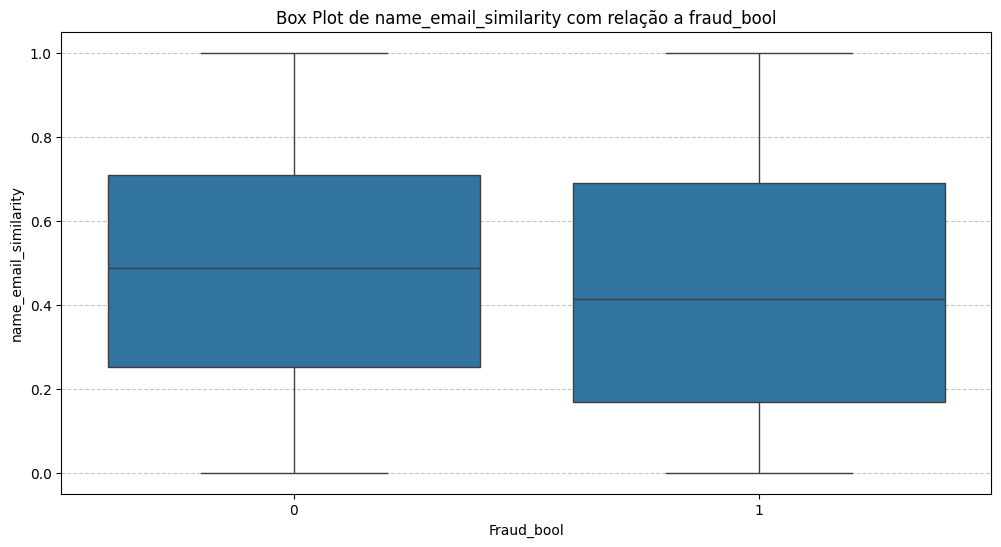

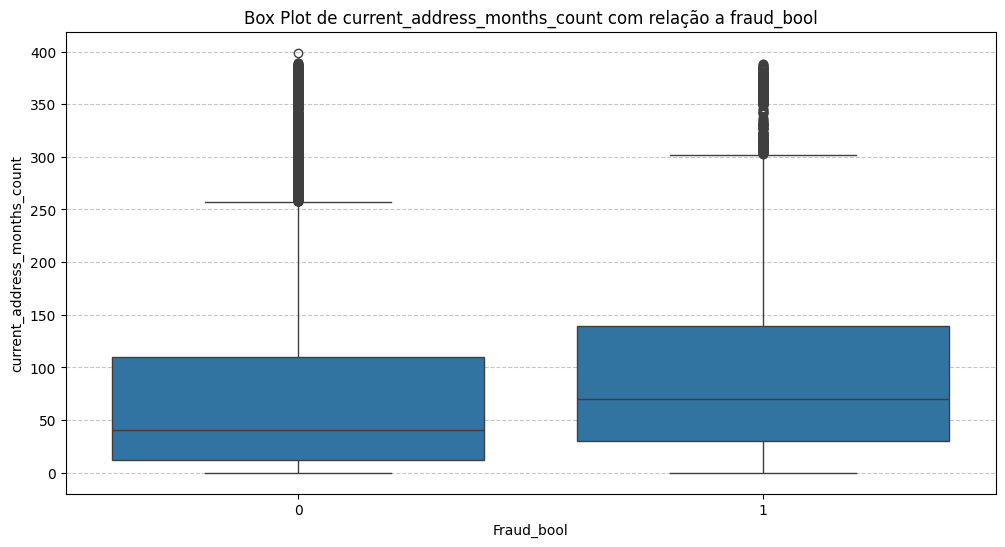

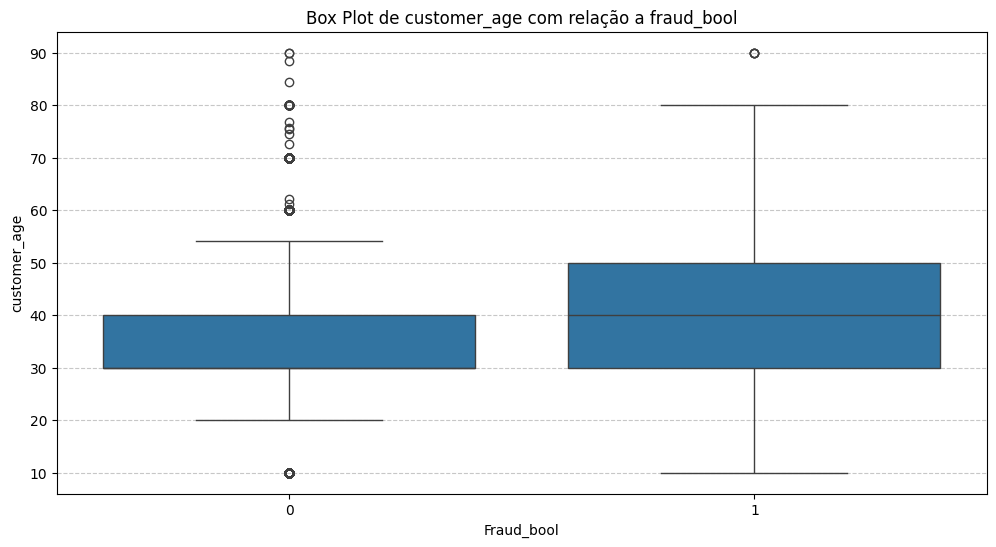

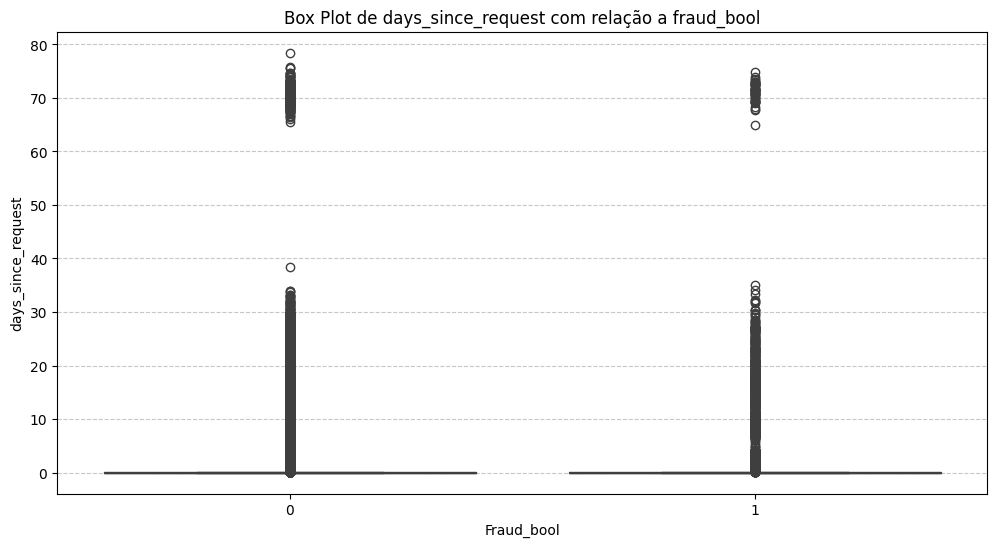

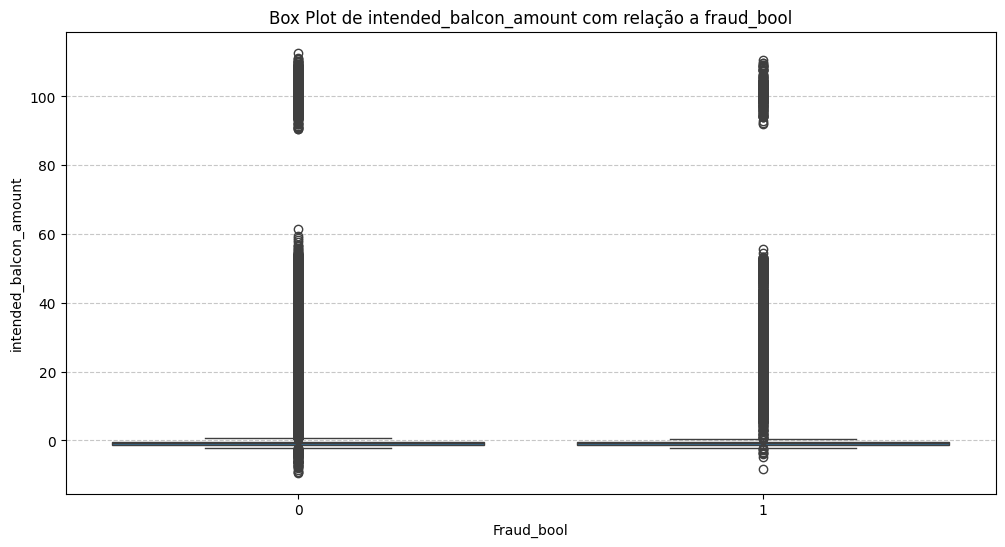

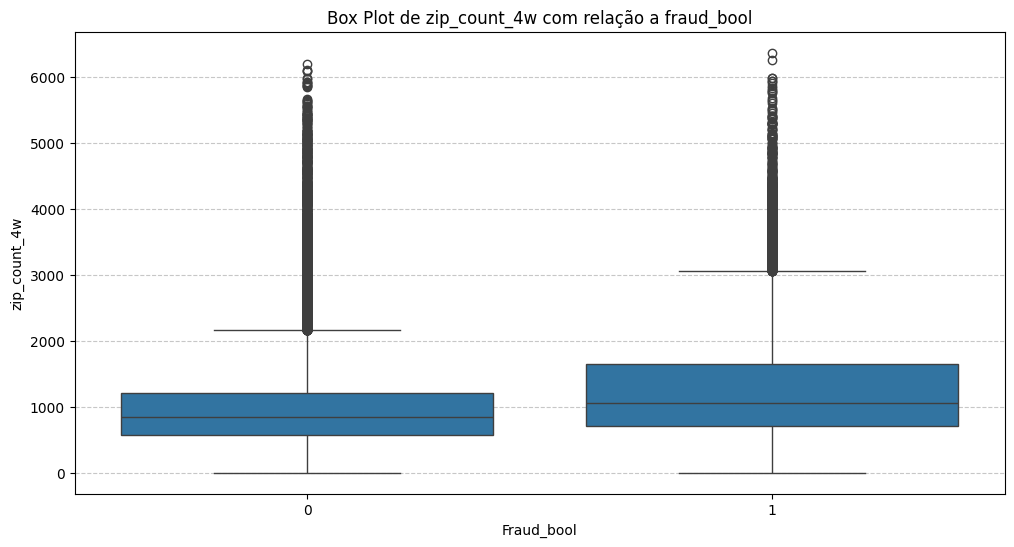

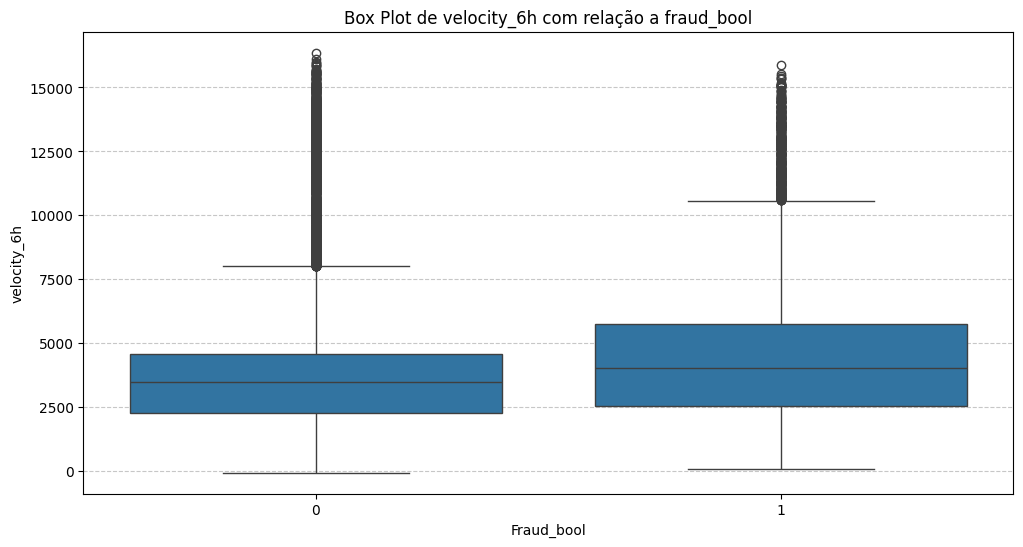

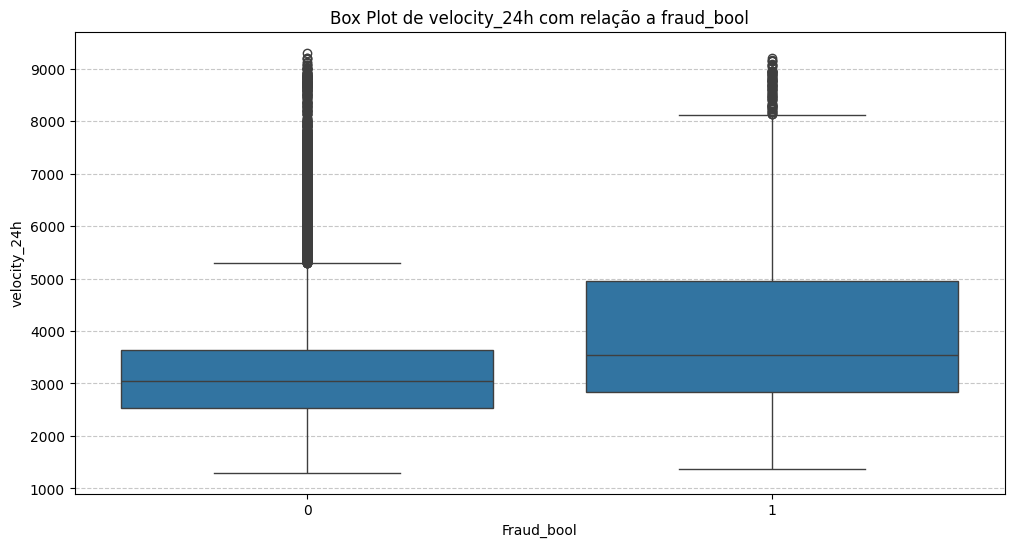

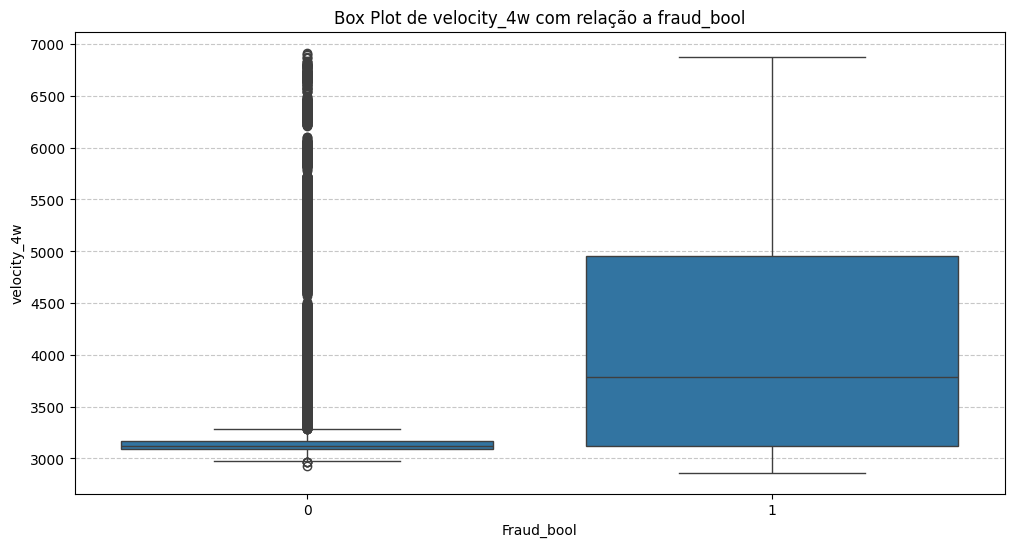

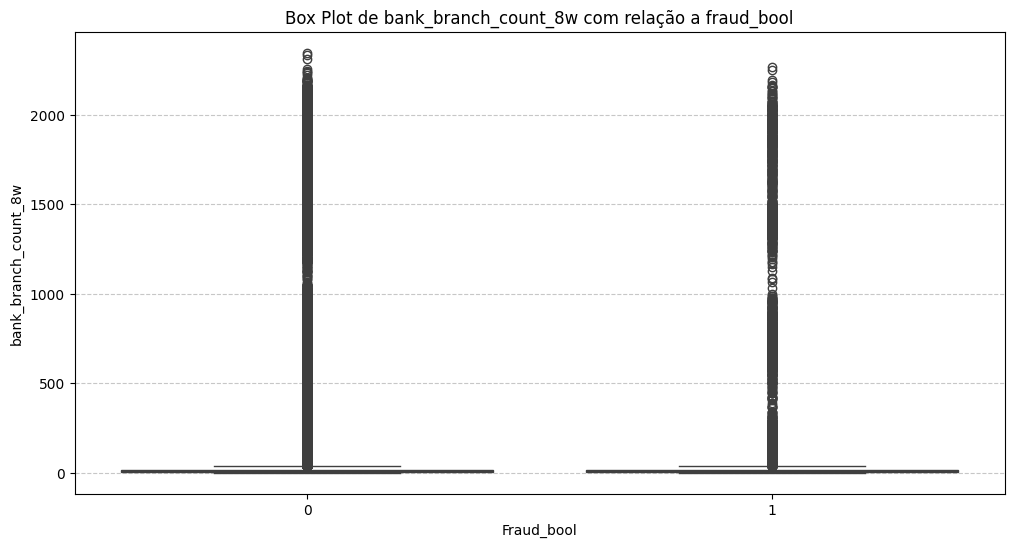

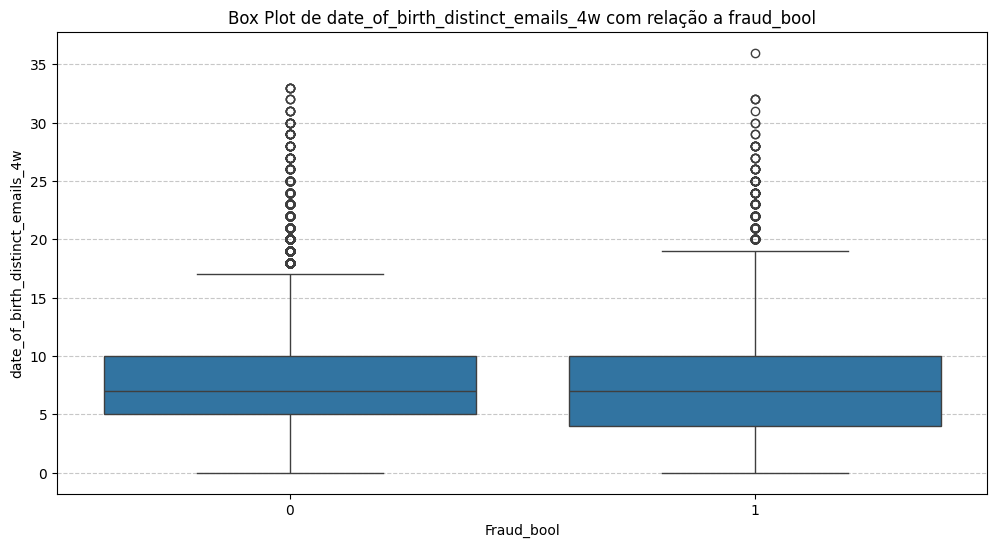

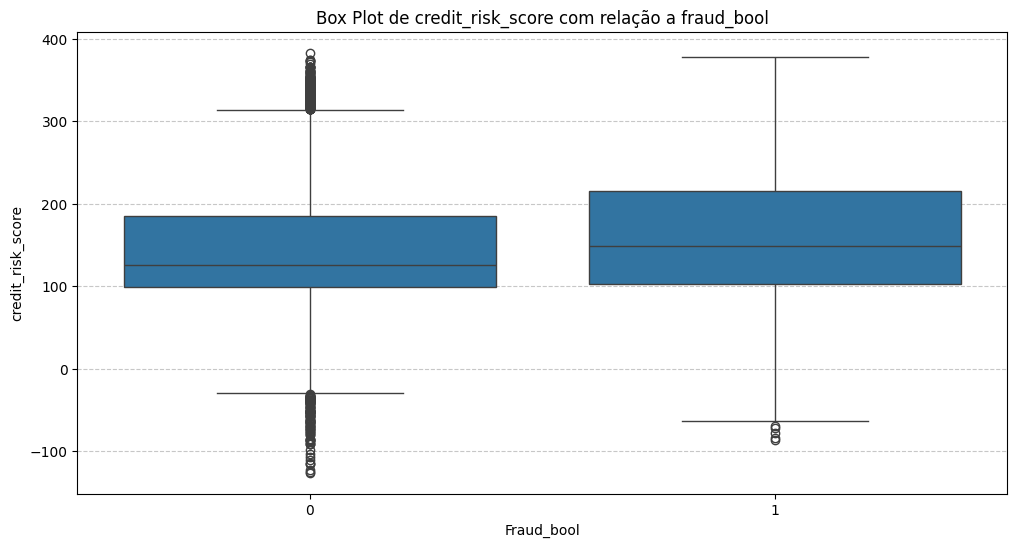

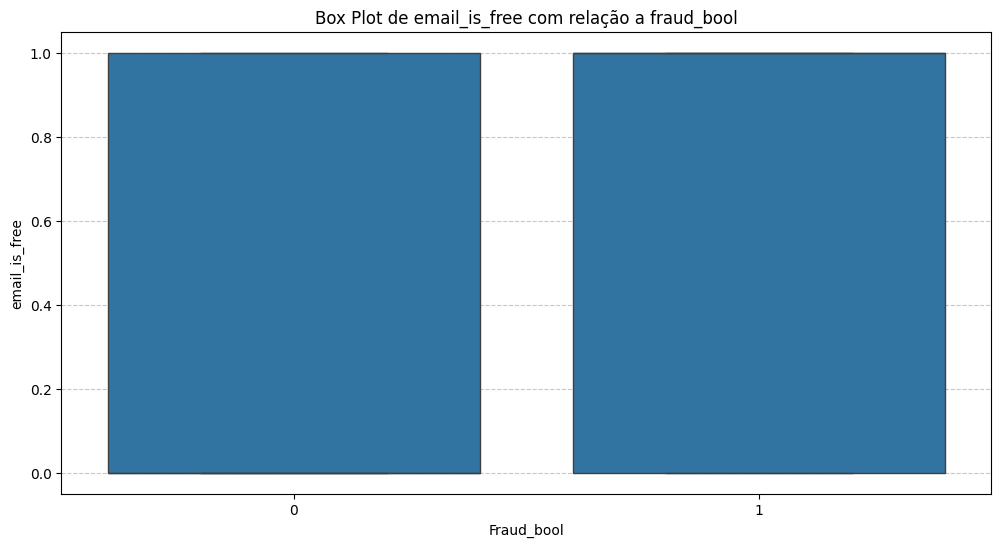

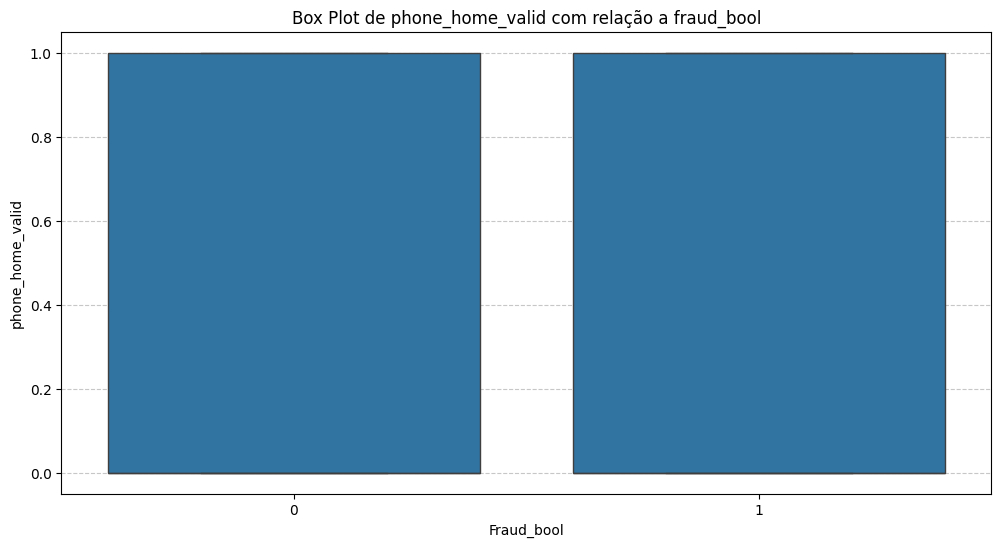

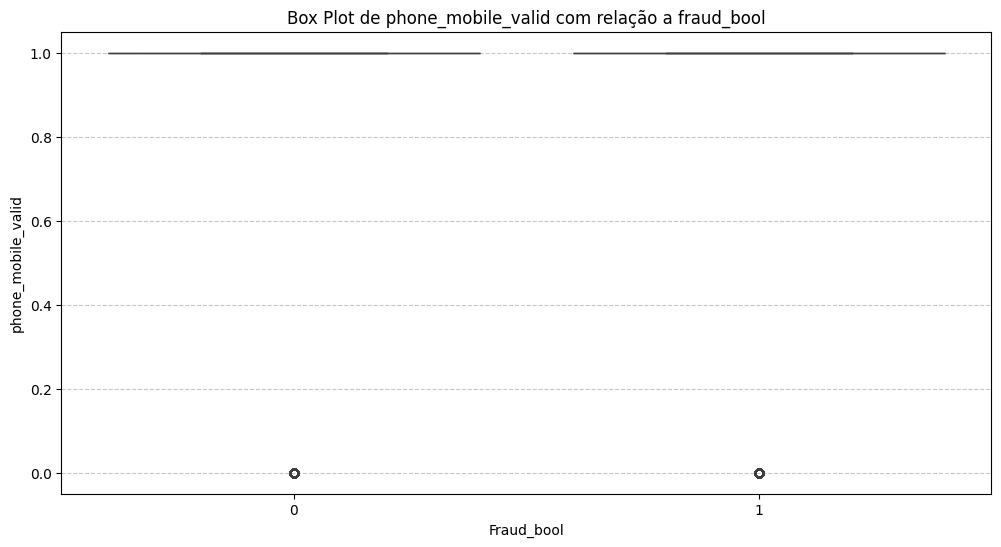

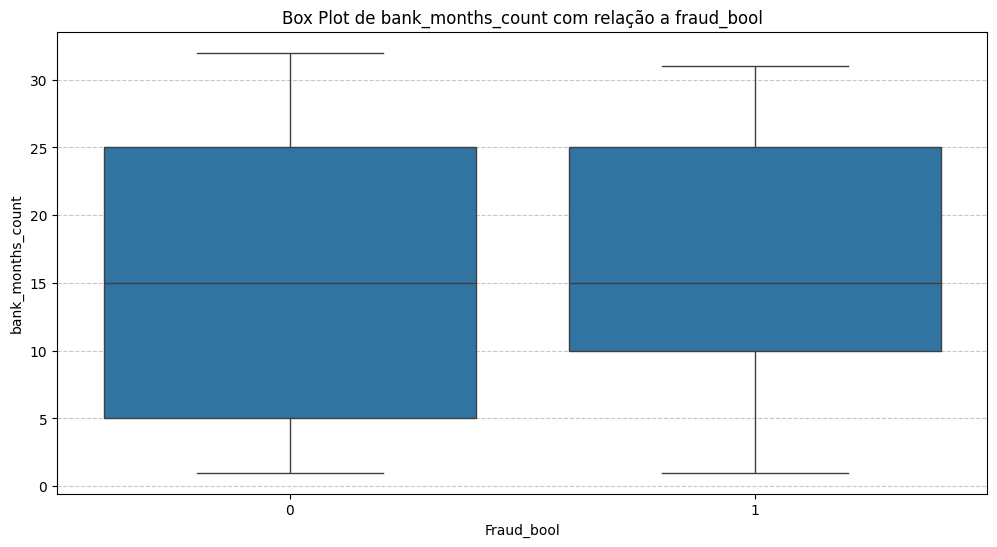

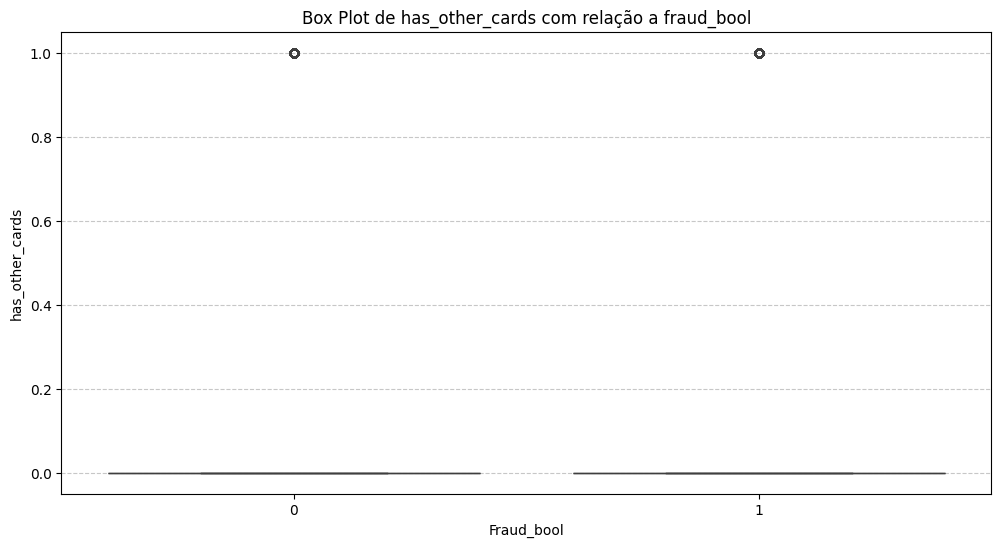

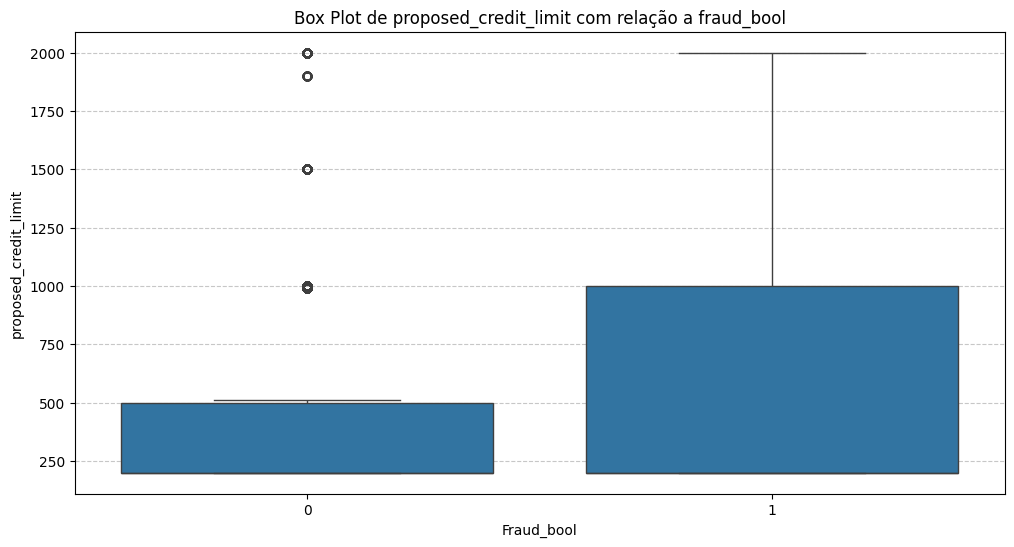

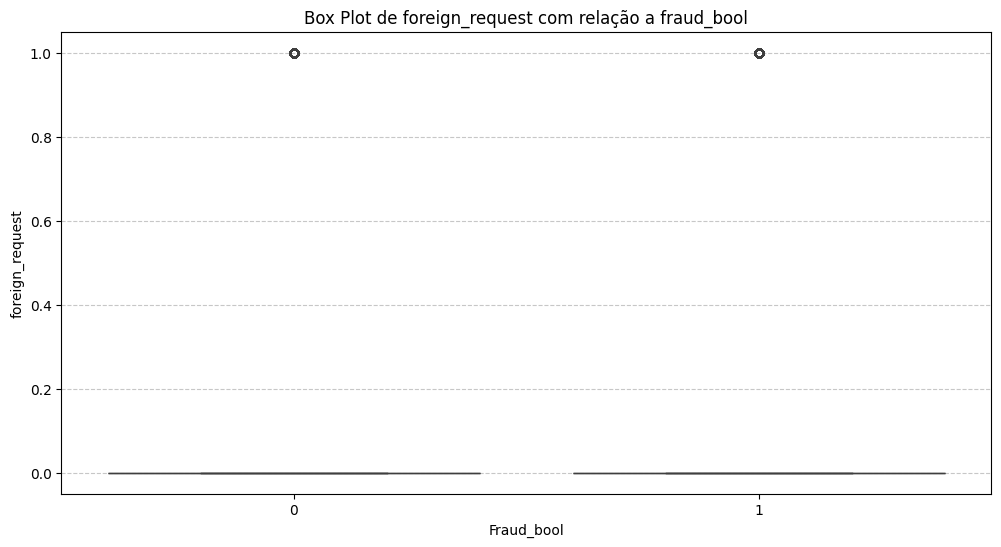

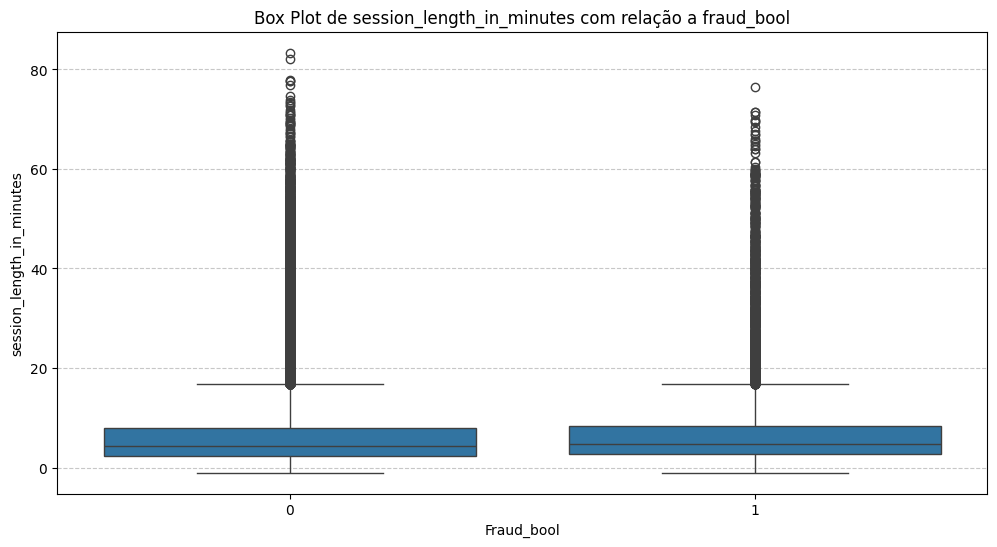

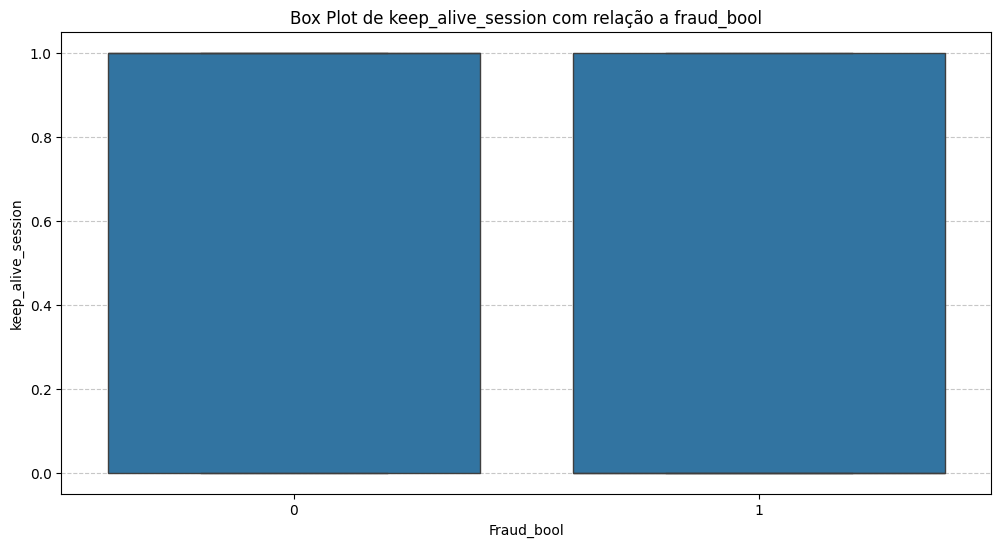

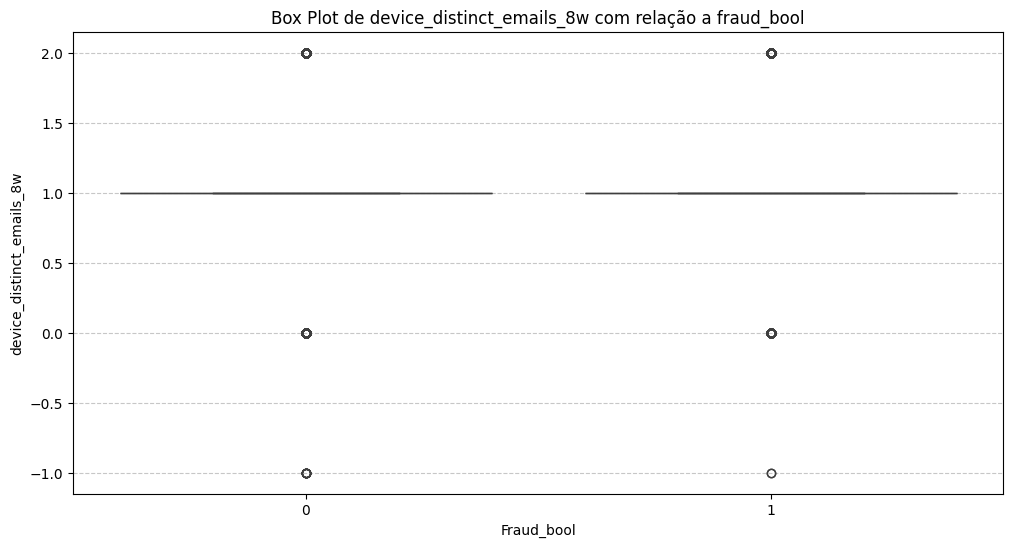

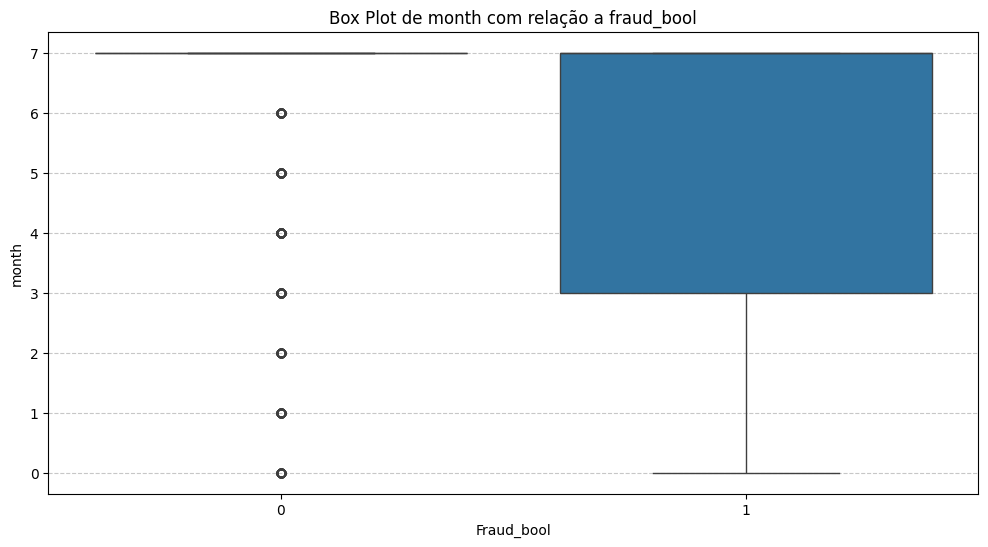

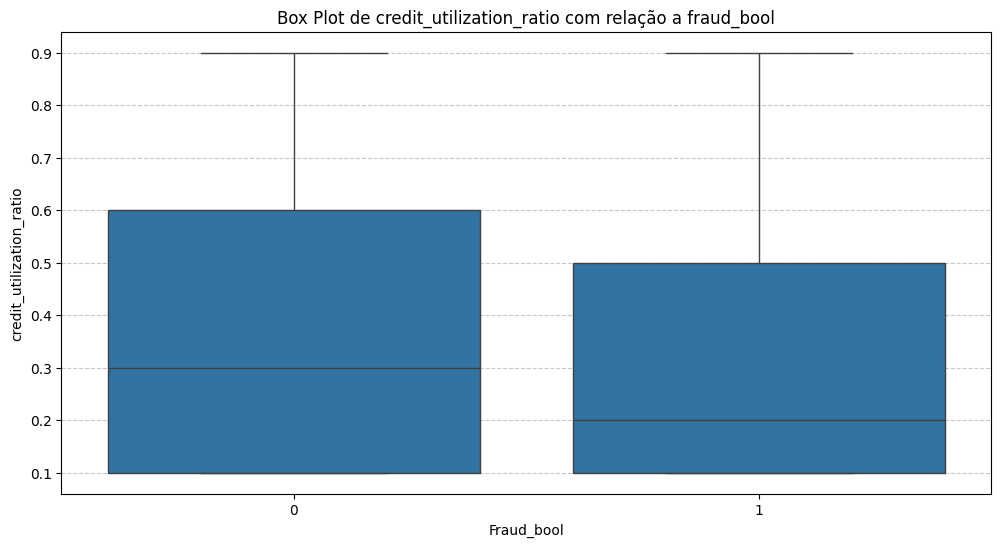

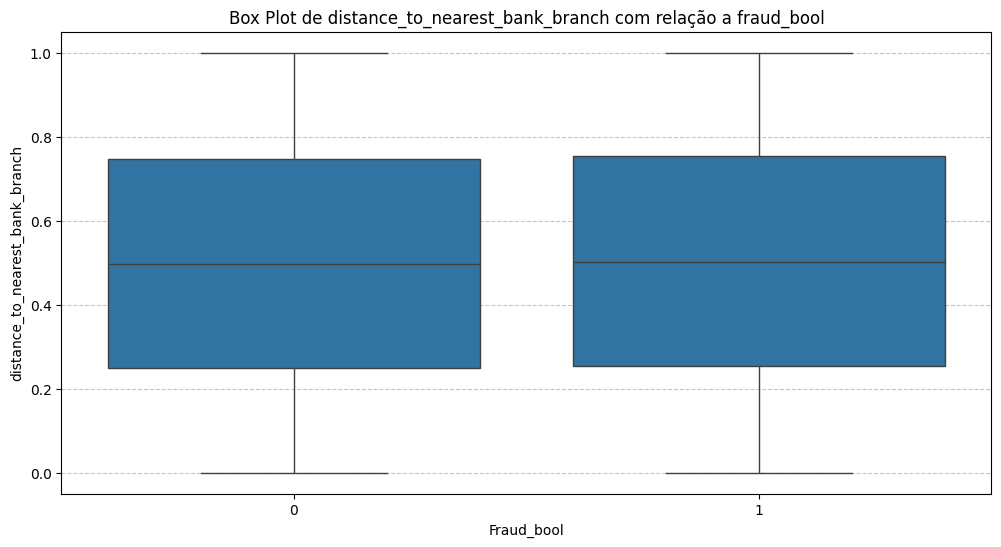

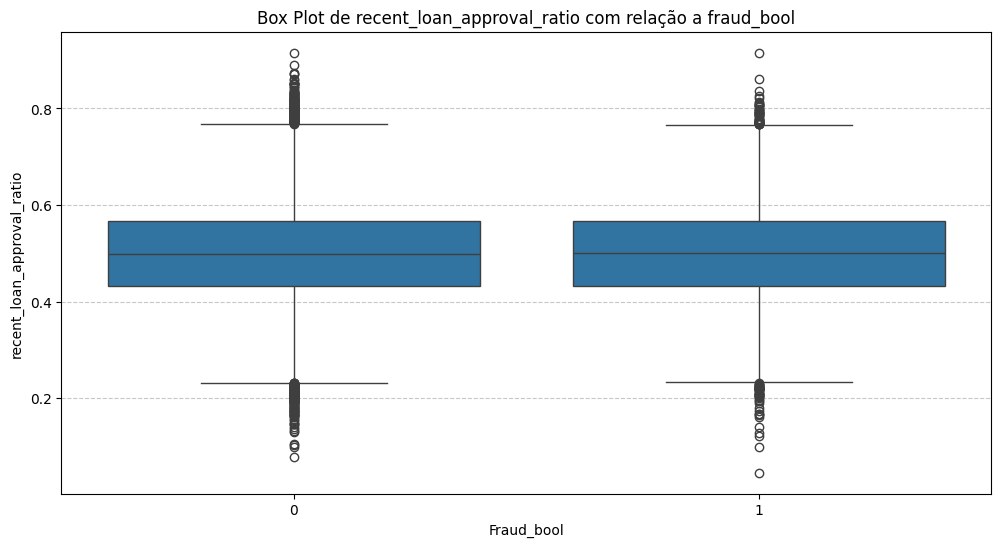

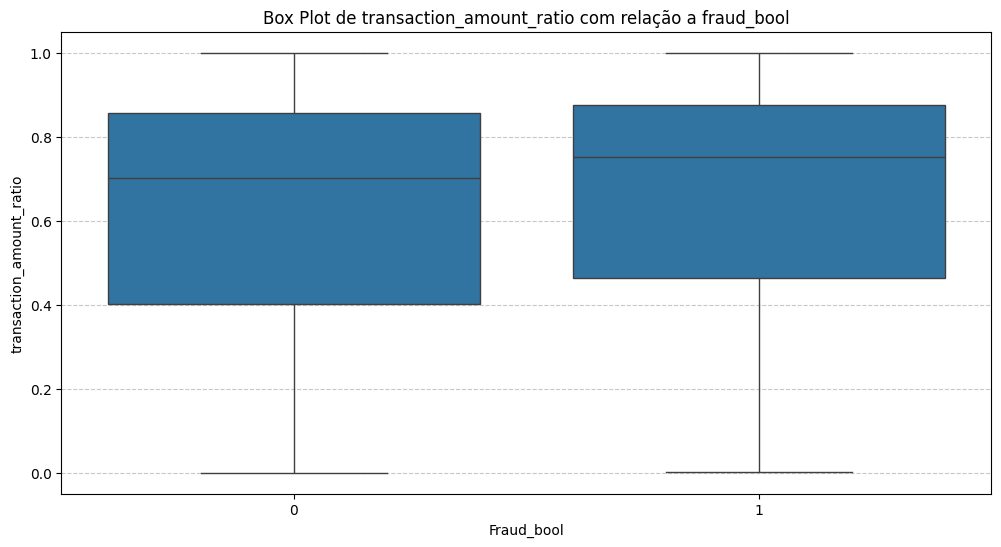

In [11]:
def plot_box_plots_with_fraud(df, fraud_column, features_to_plot, output_directory):
    for feature in features_to_plot:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=fraud_column, y=feature, data=df)
        plt.title(f'Box Plot de {feature} com relação a {fraud_column}')
        plt.xlabel(fraud_column.capitalize())
        plt.ylabel(feature)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig(os.path.join(output_directory, f'box_plot_{feature}_{fraud_column}.png'))
        plt.show()

# Exemplo de uso:
output_directory = 'plots'
features_to_plot = df.select_dtypes(include='number').columns
features_to_plot = features_to_plot.drop('fraud_bool')
plot_box_plots_with_fraud(df, 'fraud_bool', features_to_plot, output_directory)

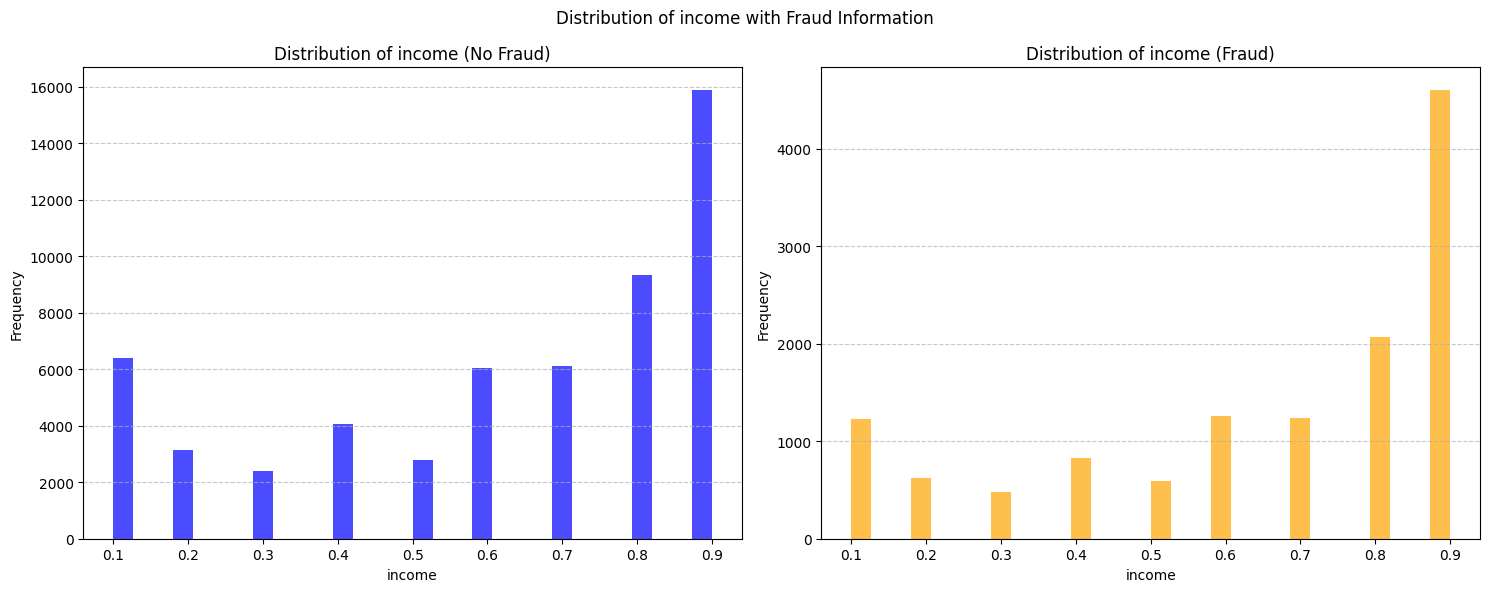

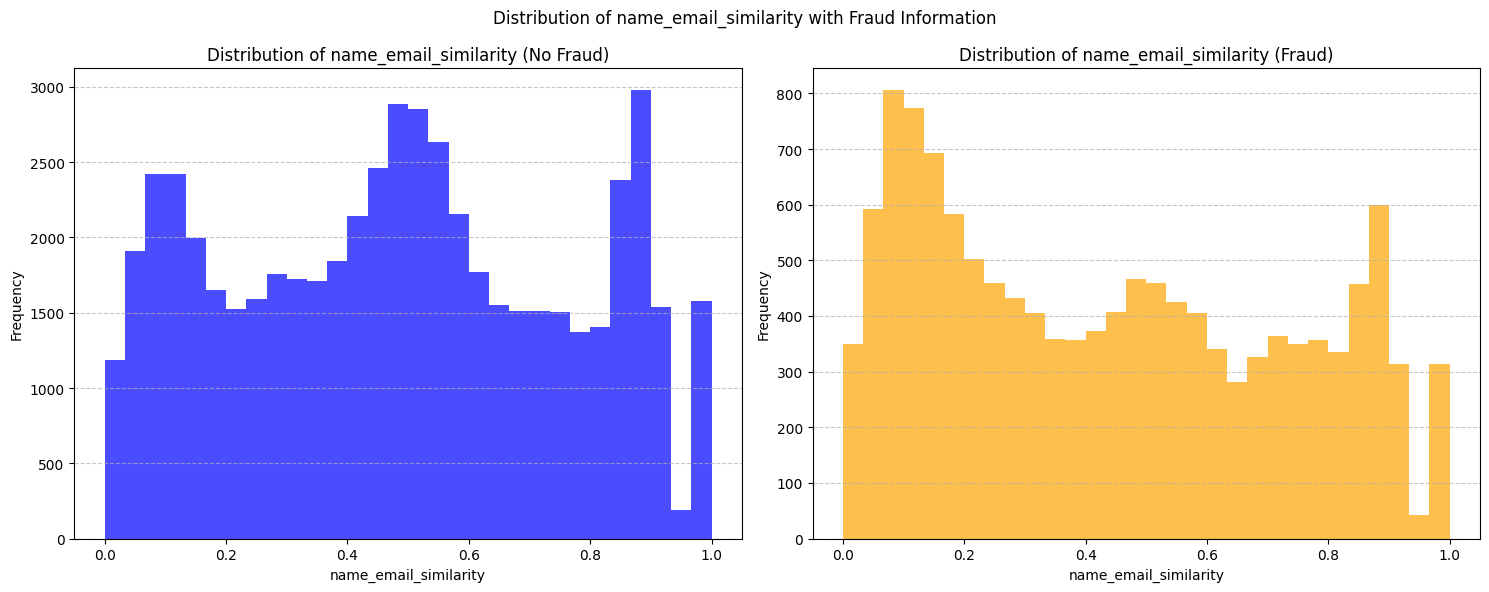

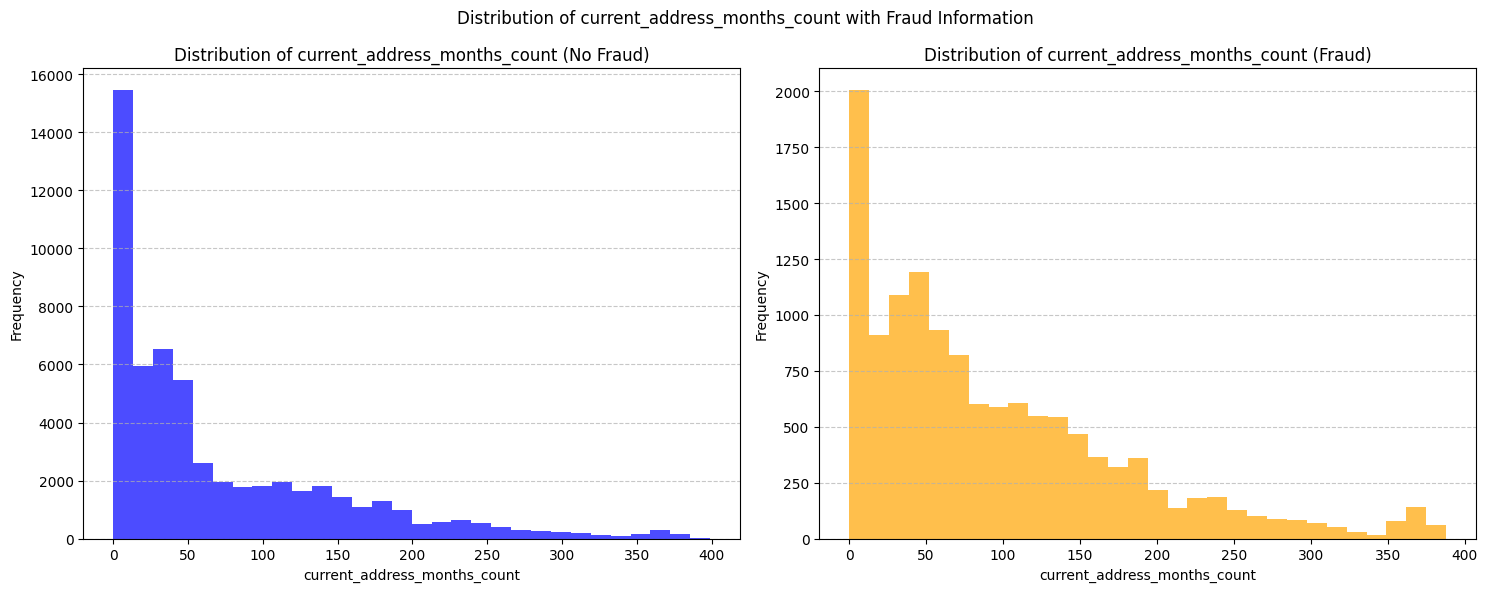

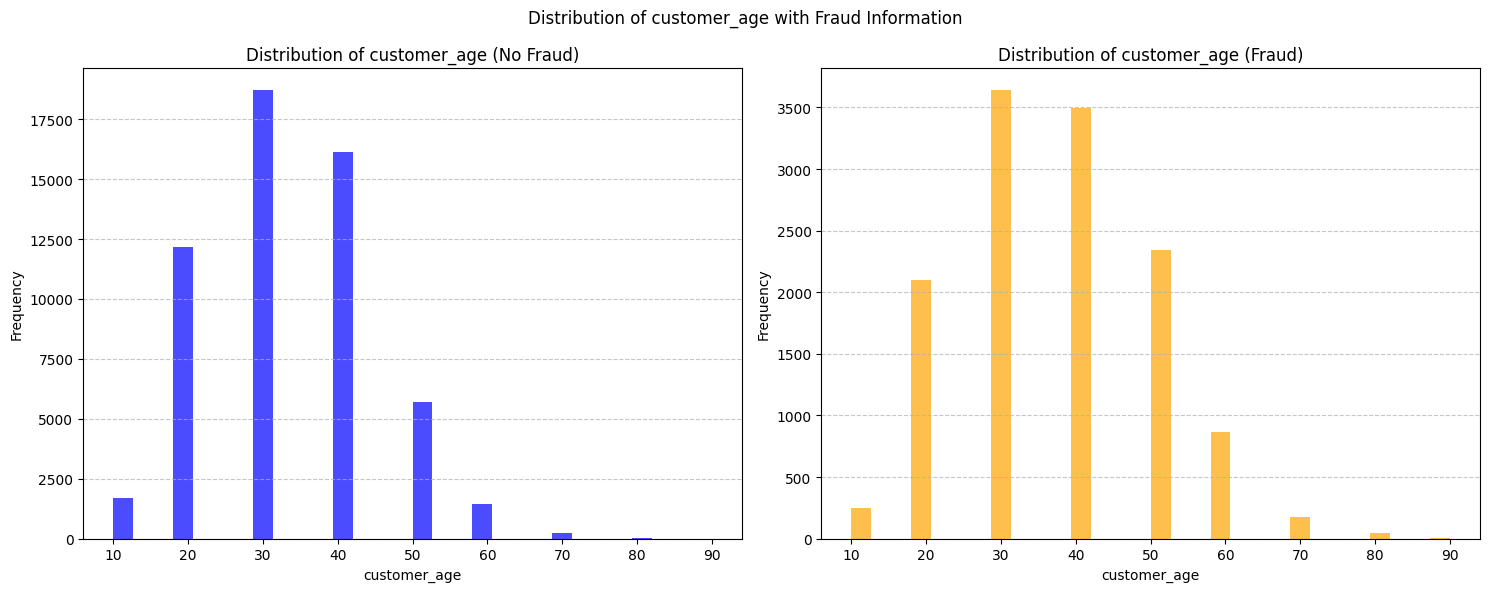

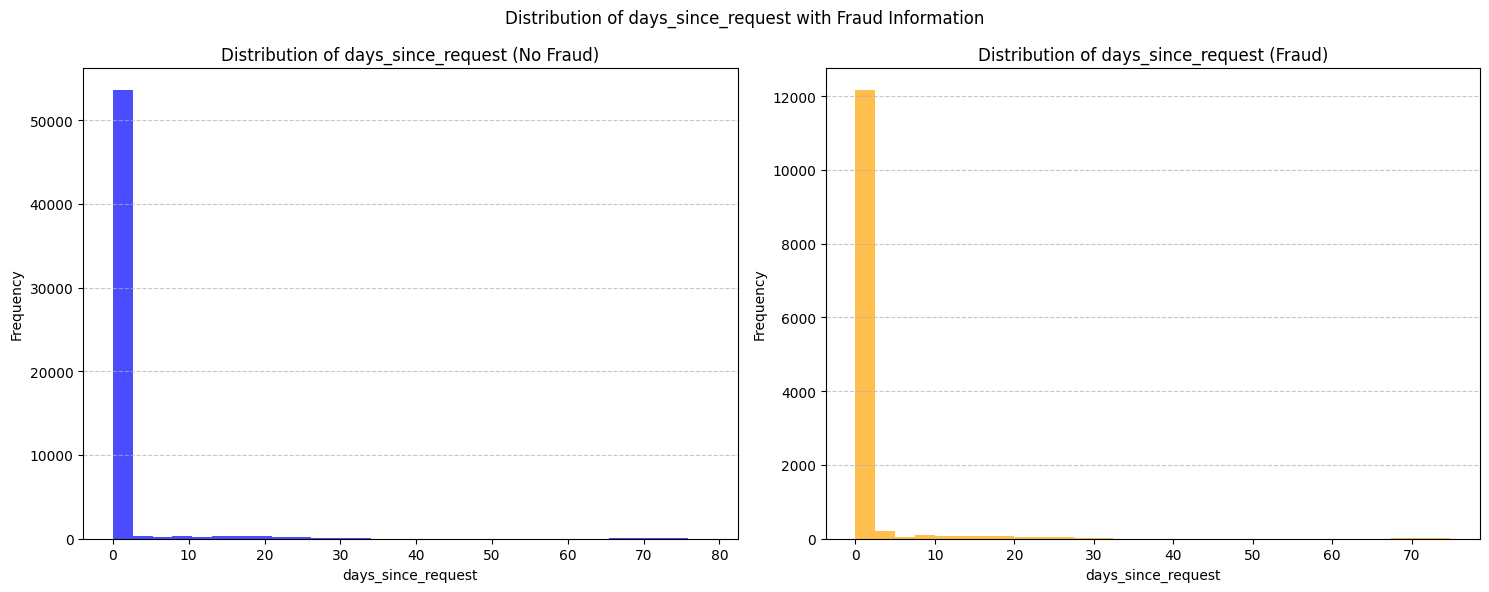

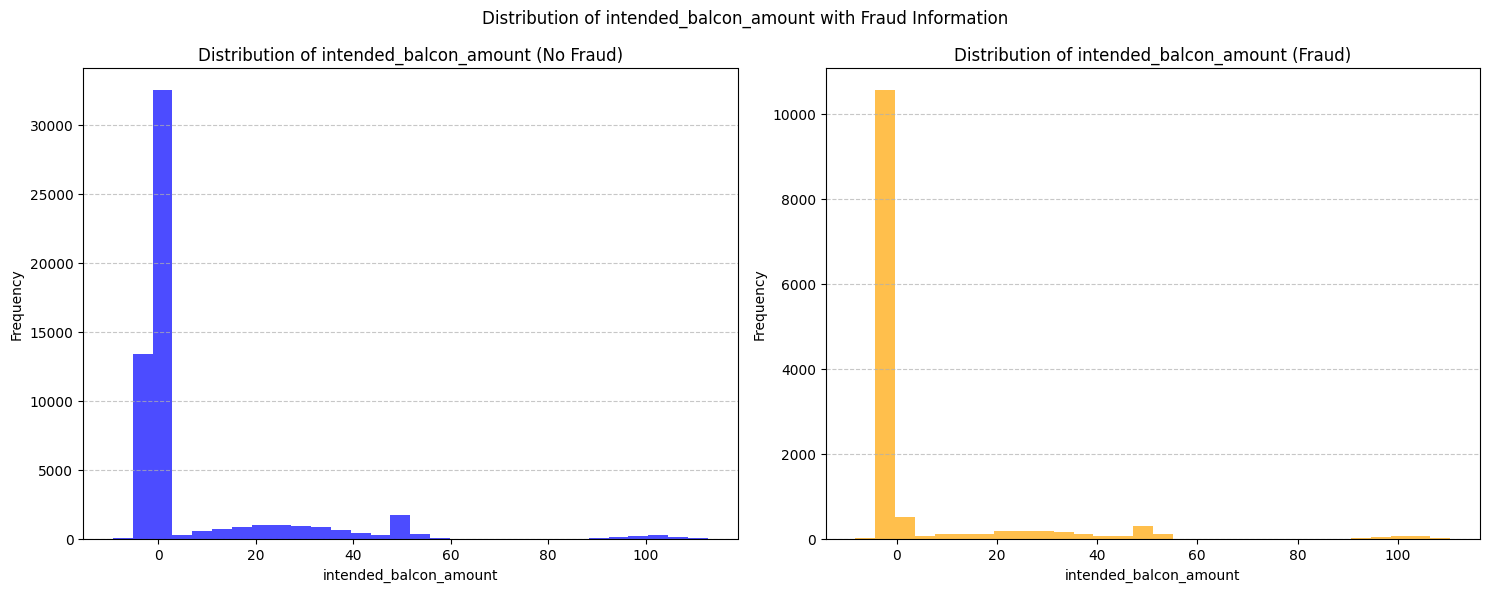

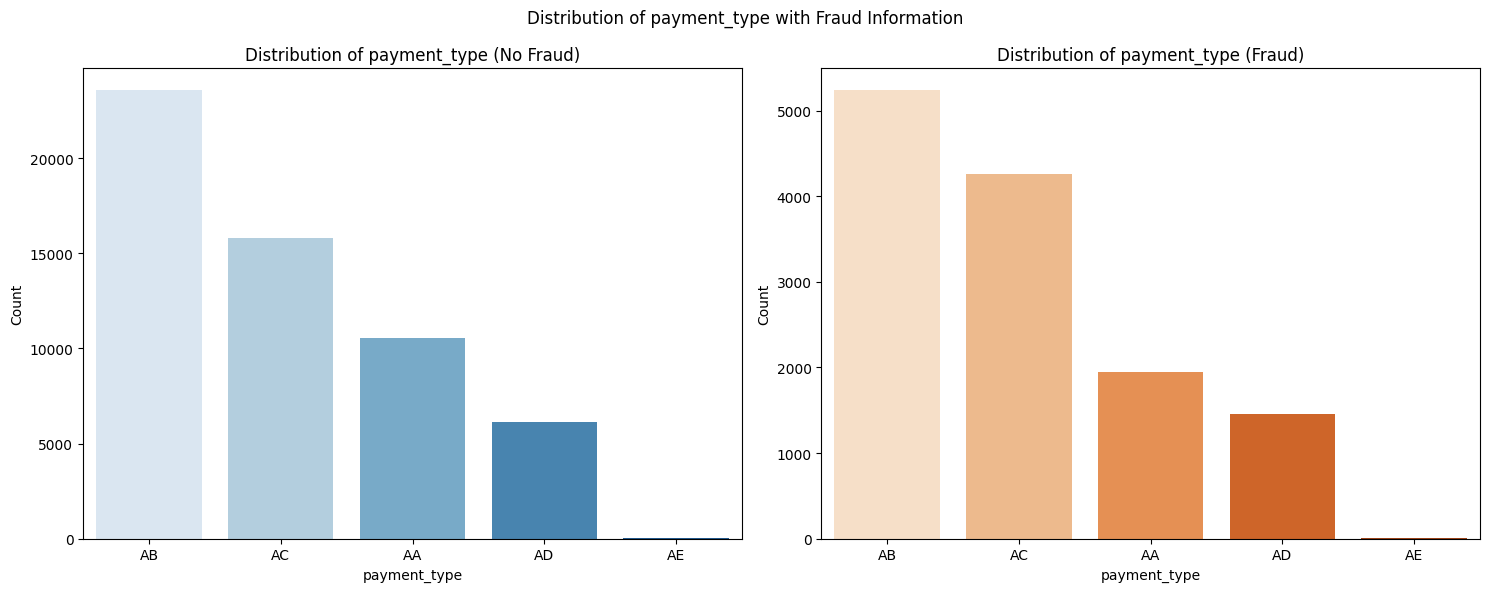

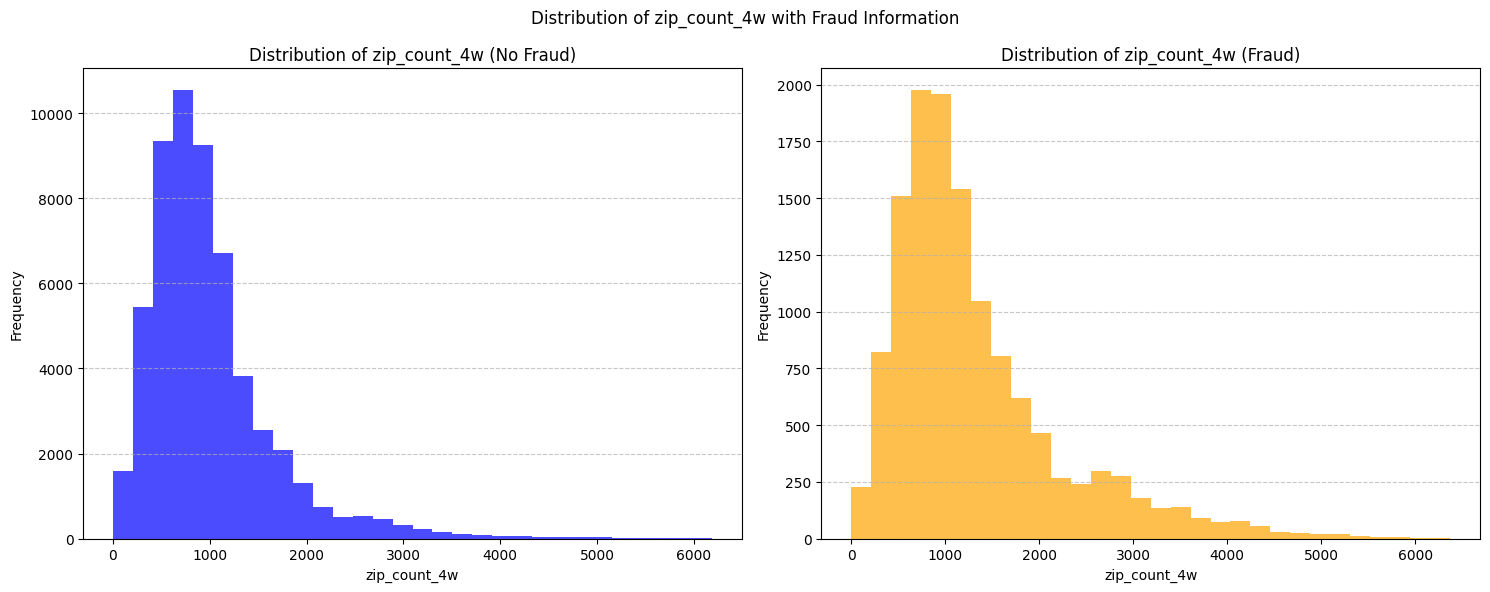

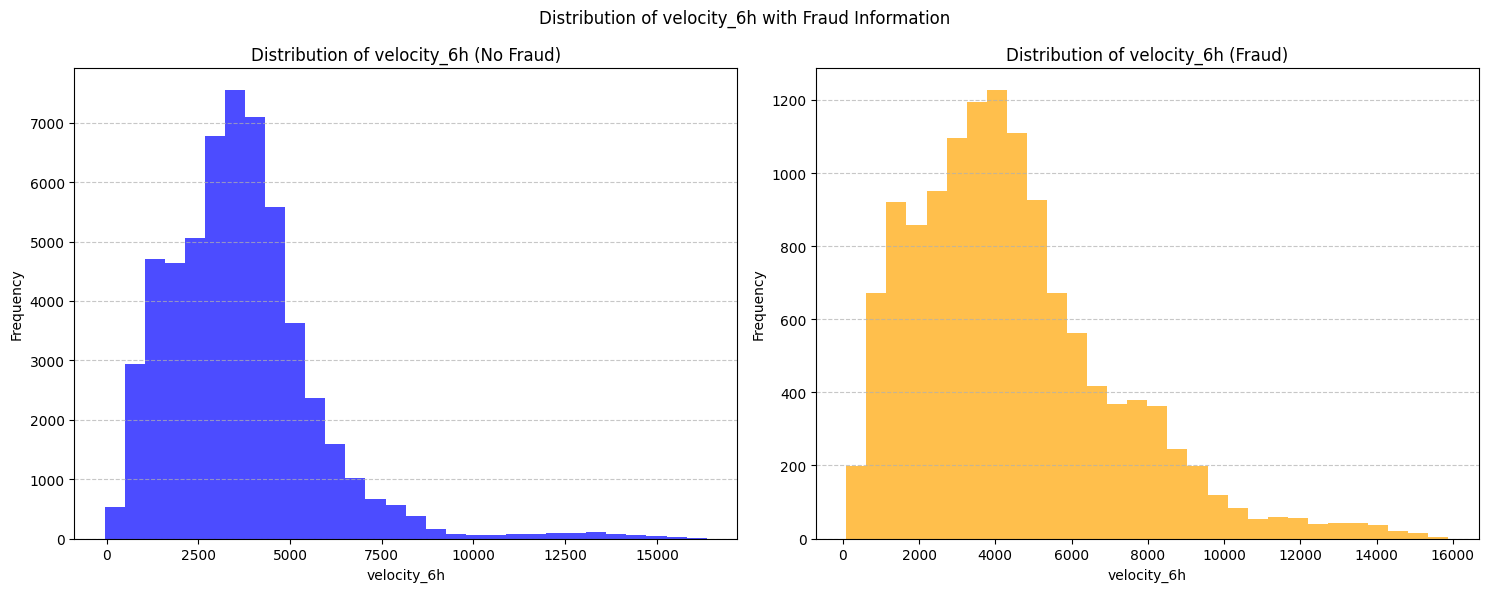

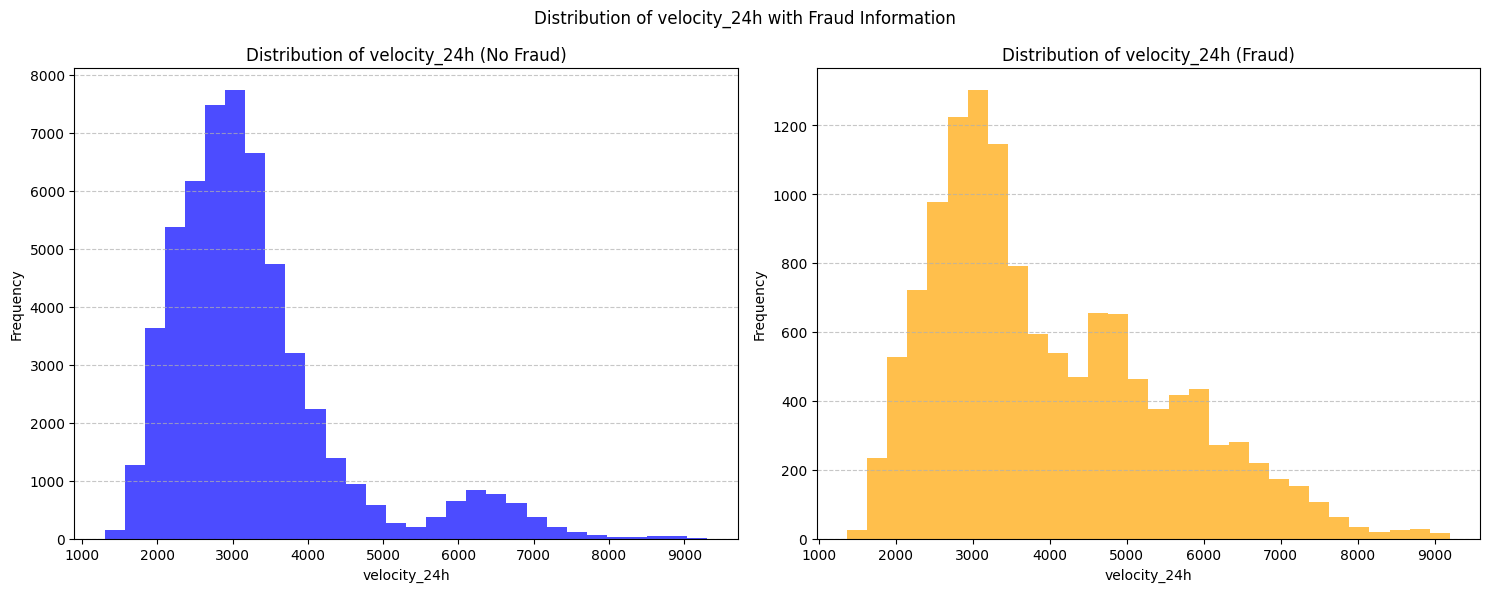

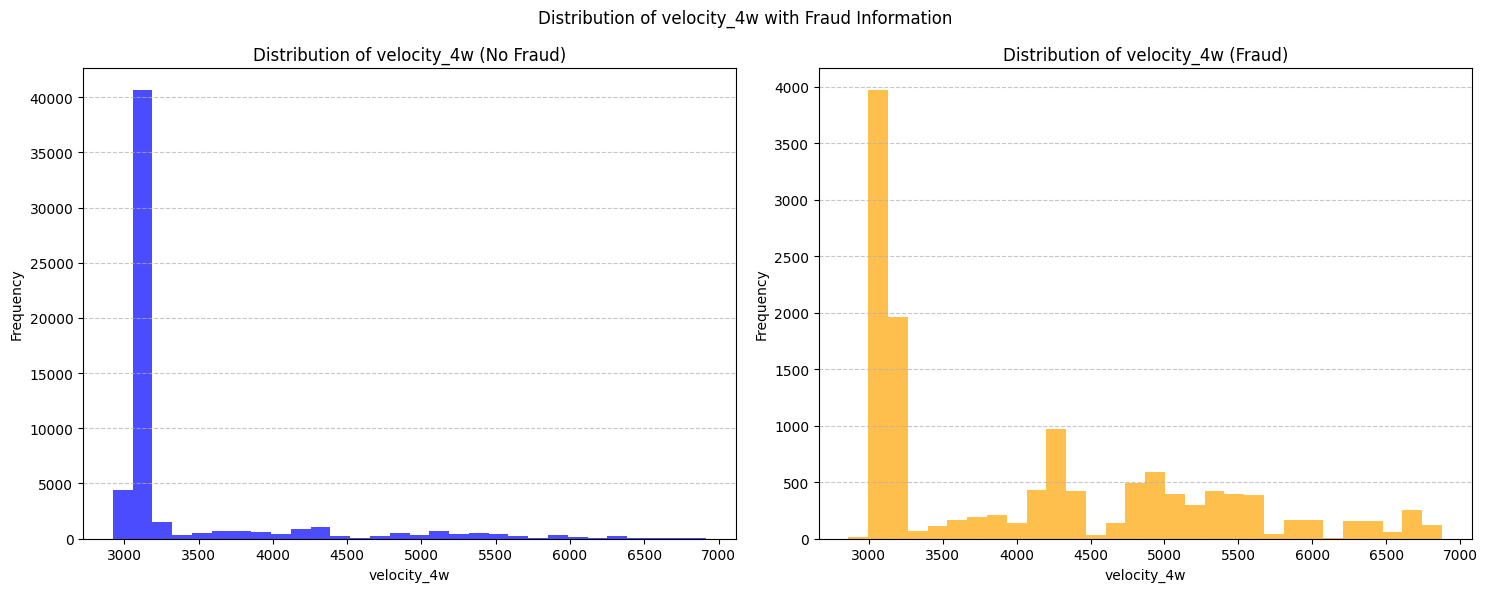

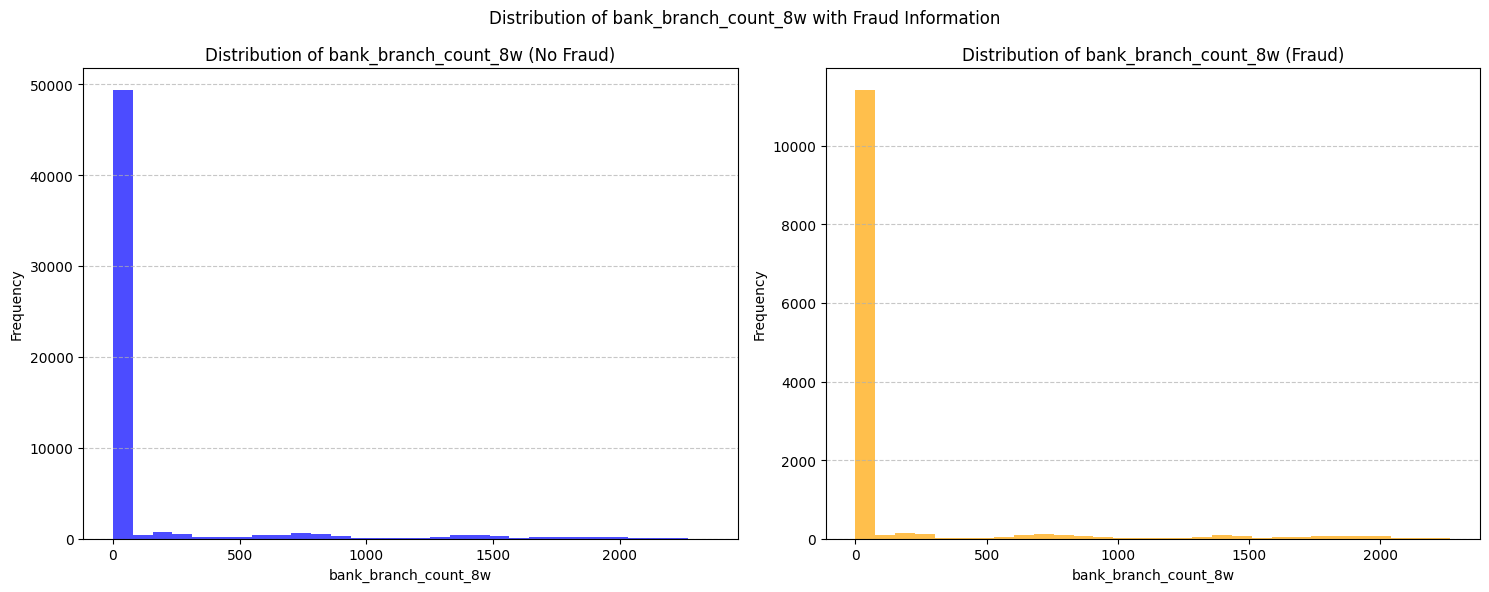

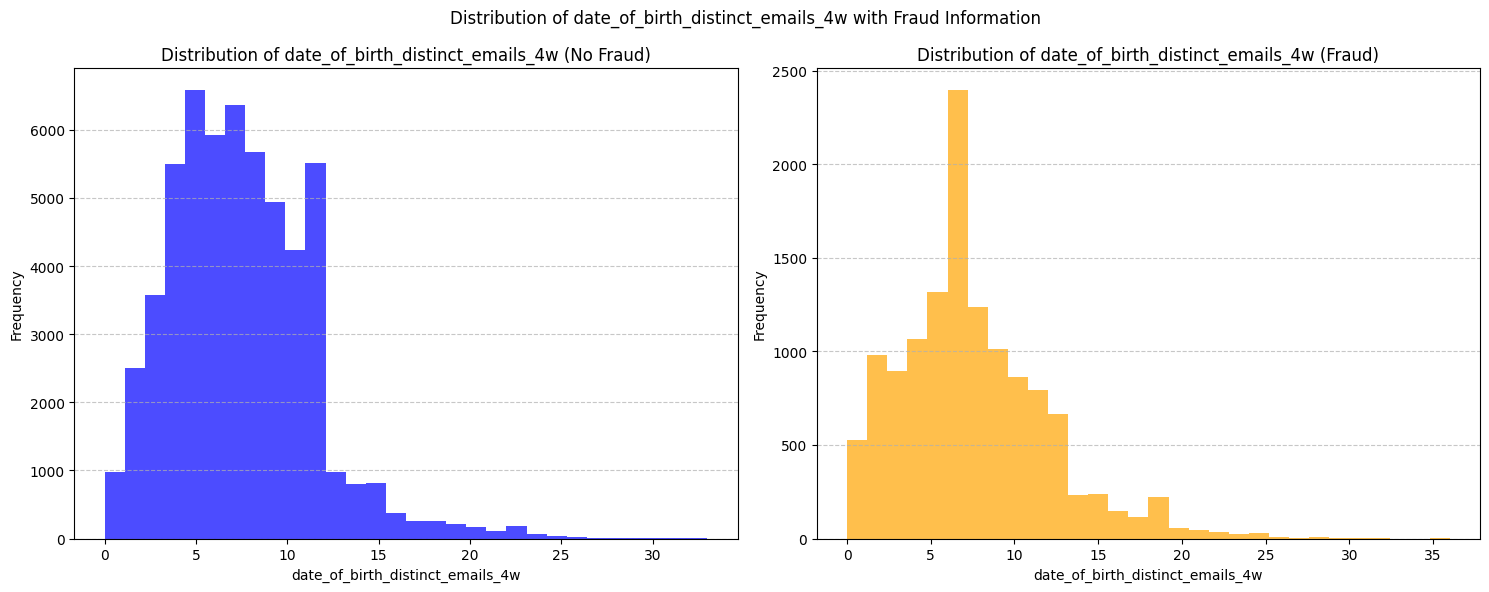

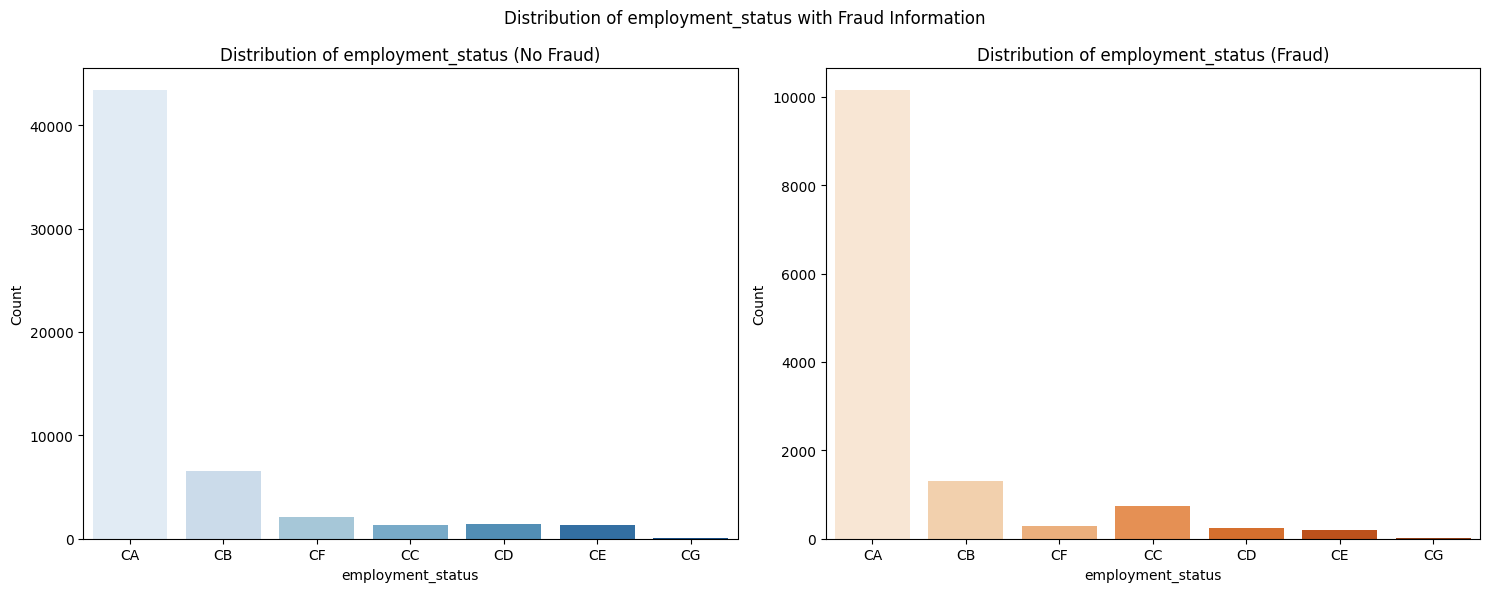

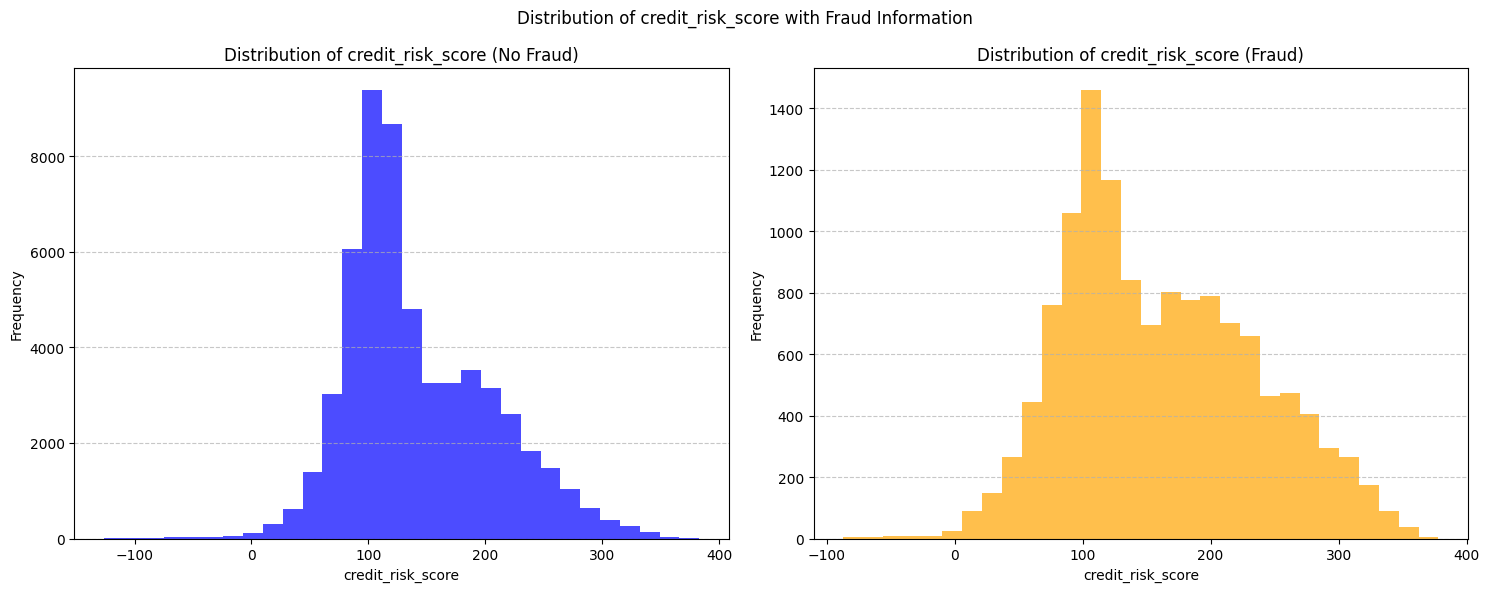

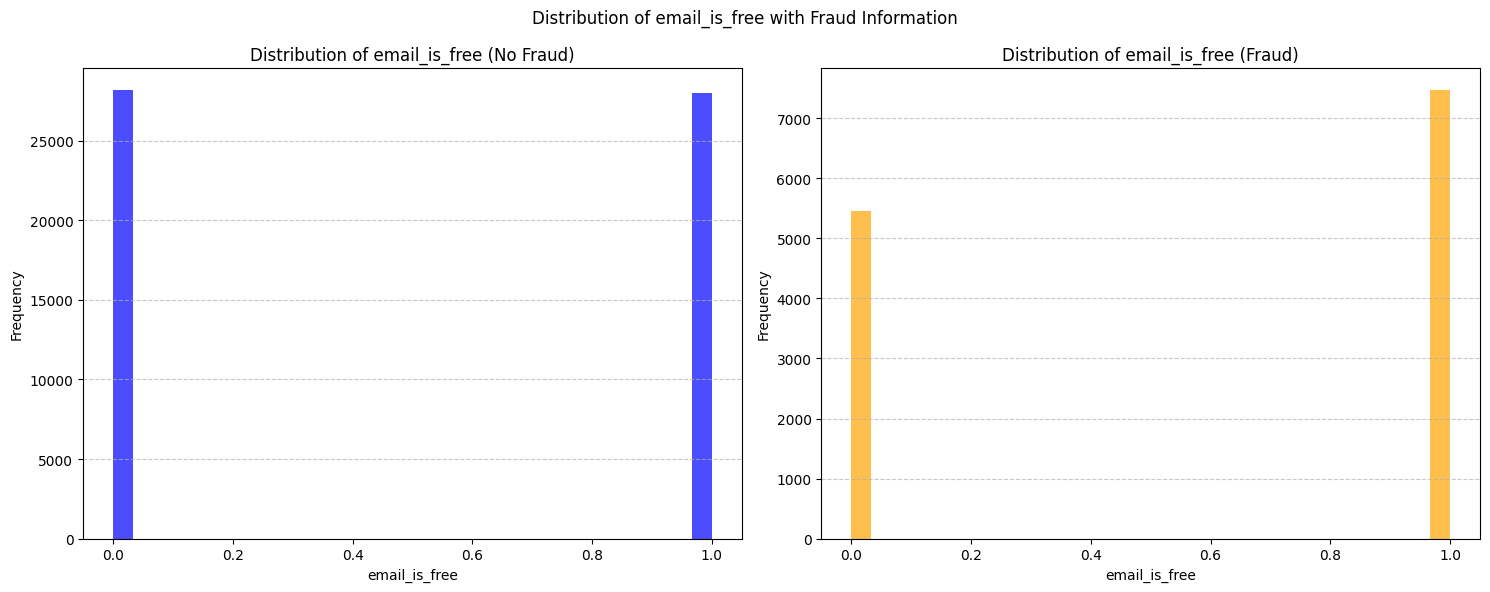

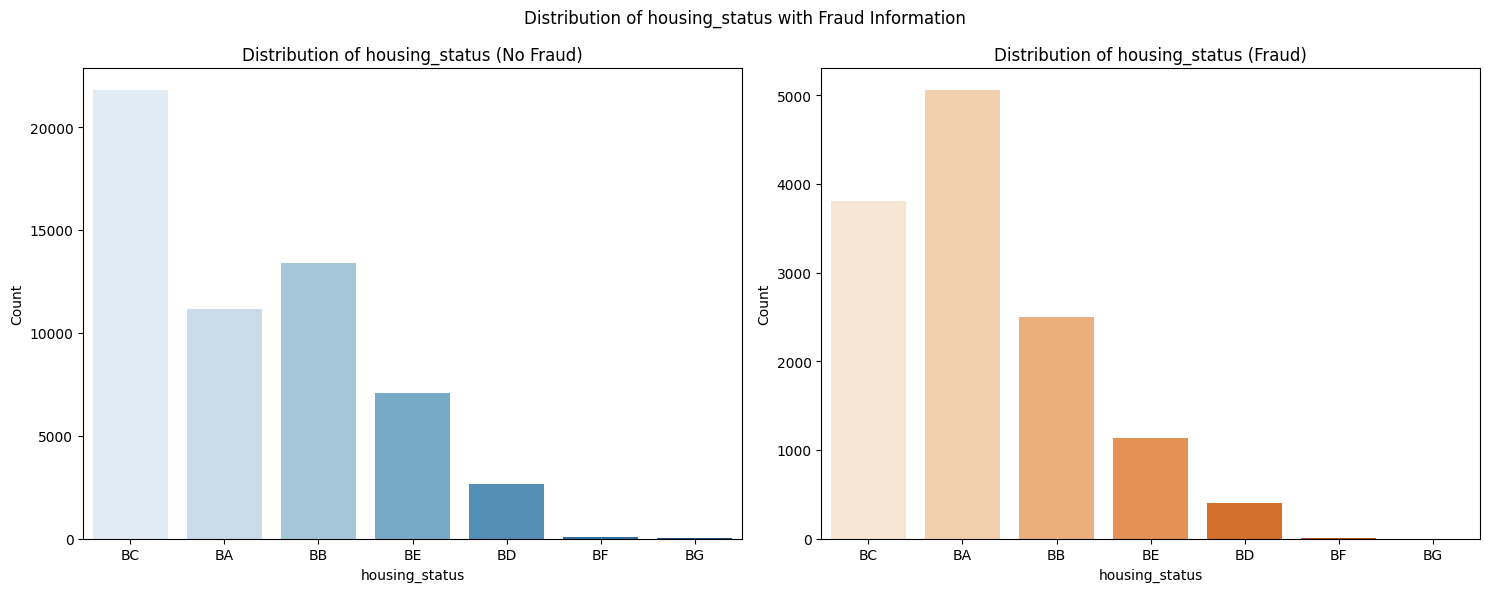

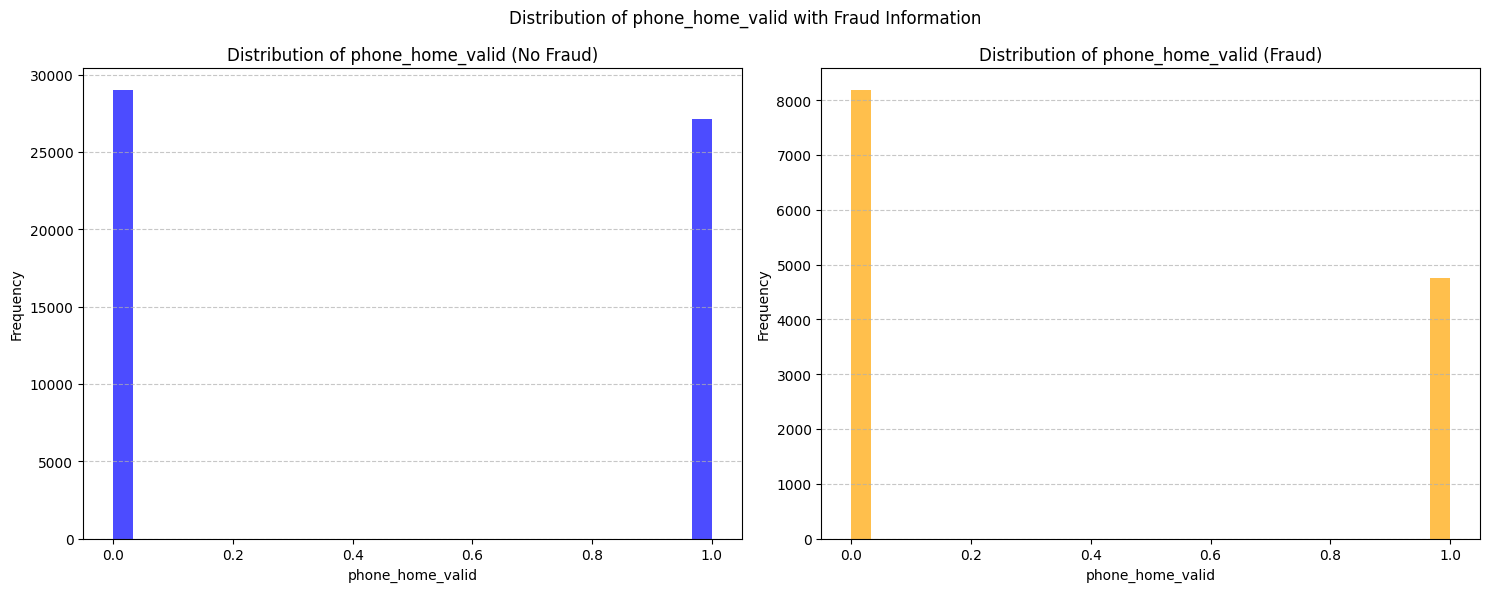

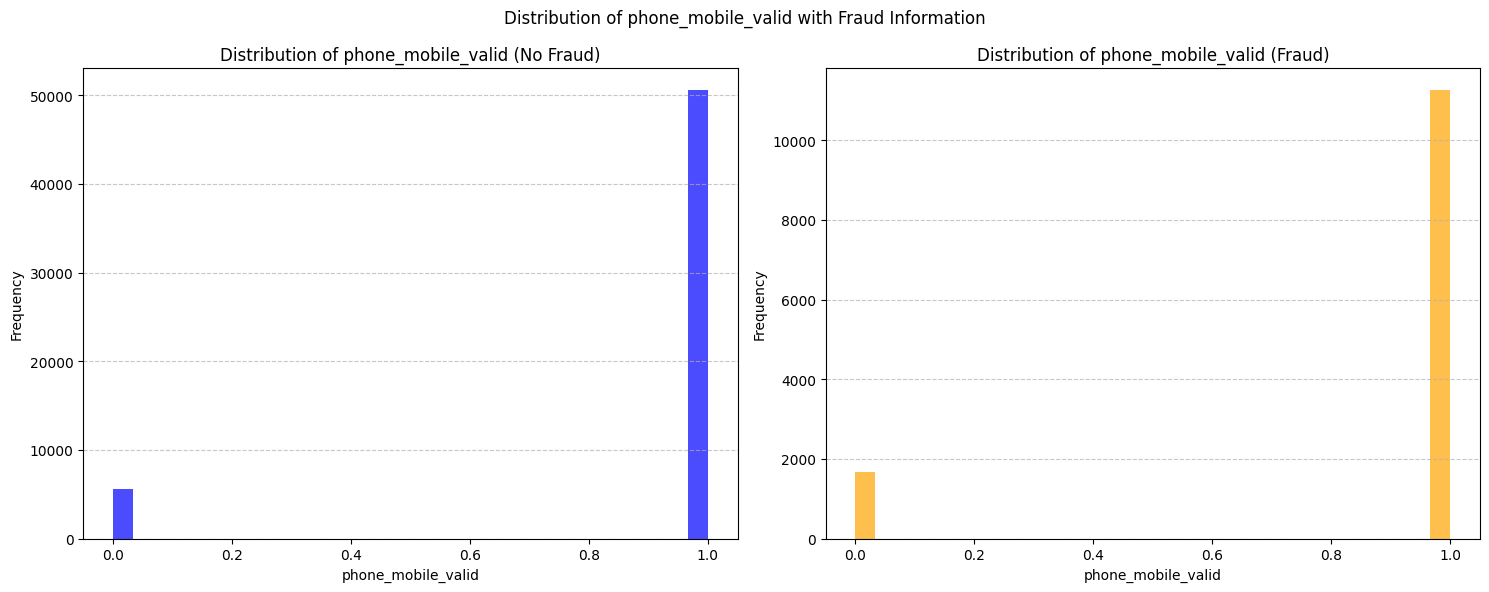

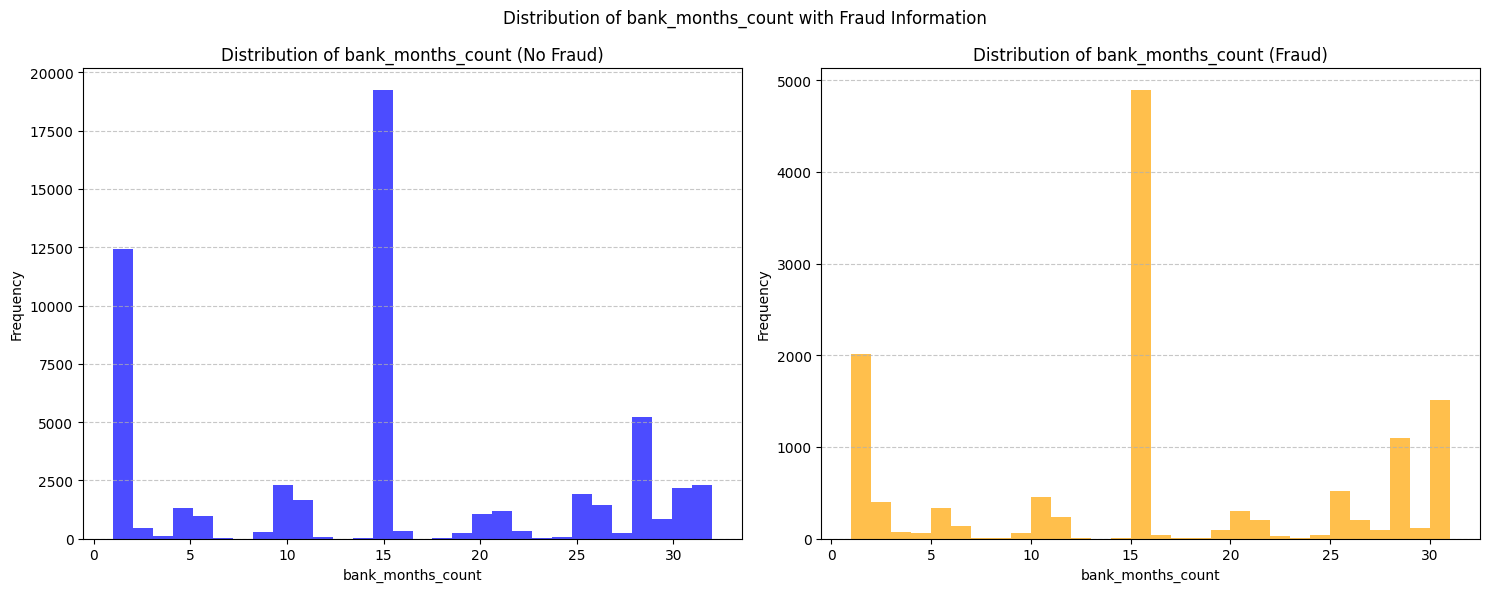

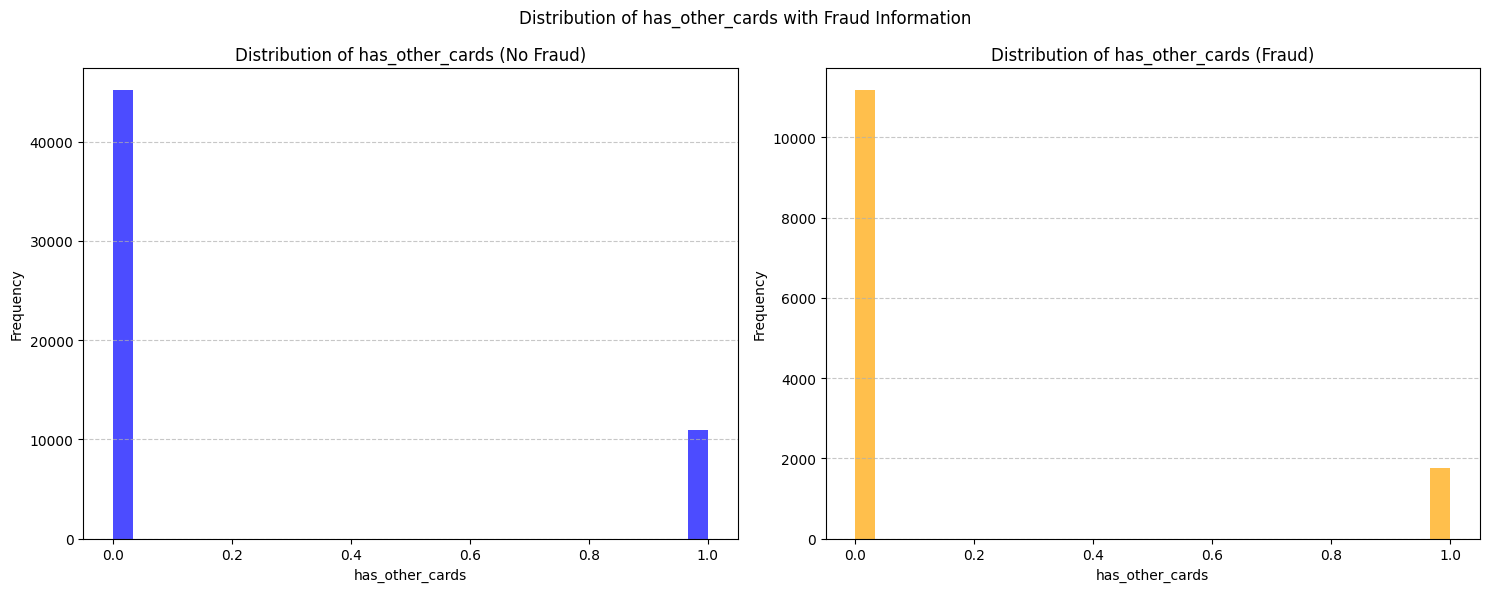

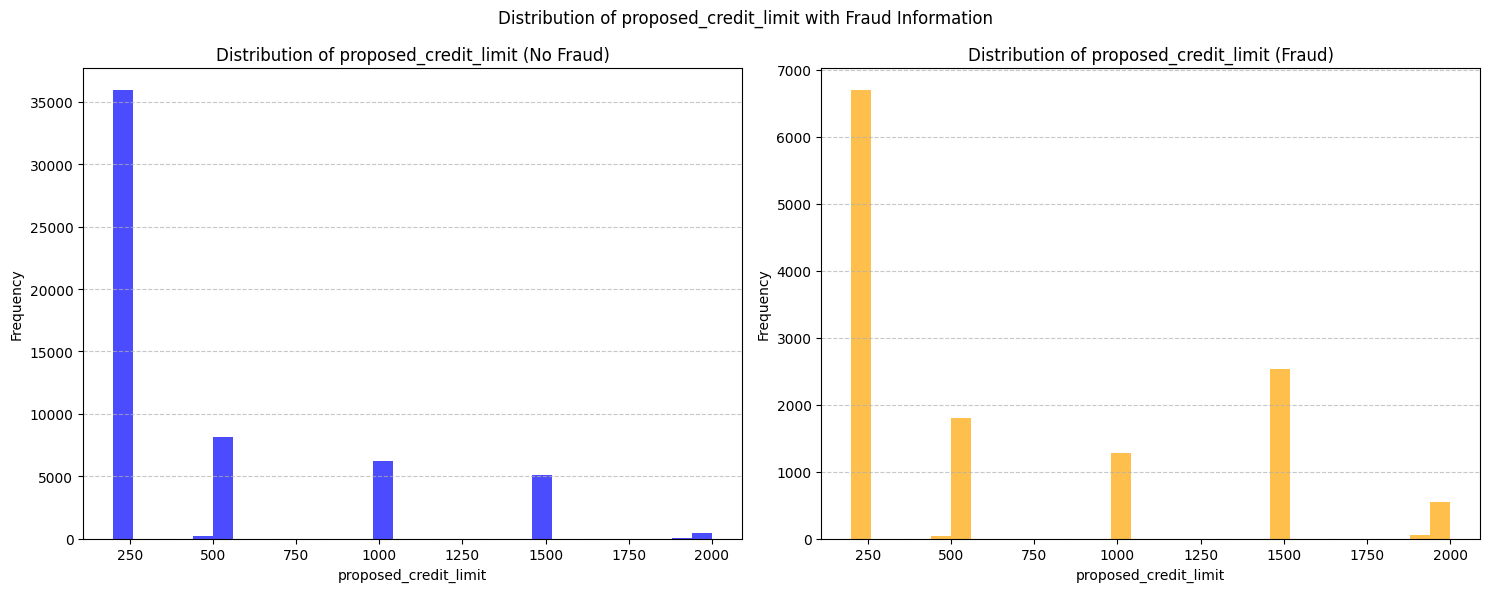

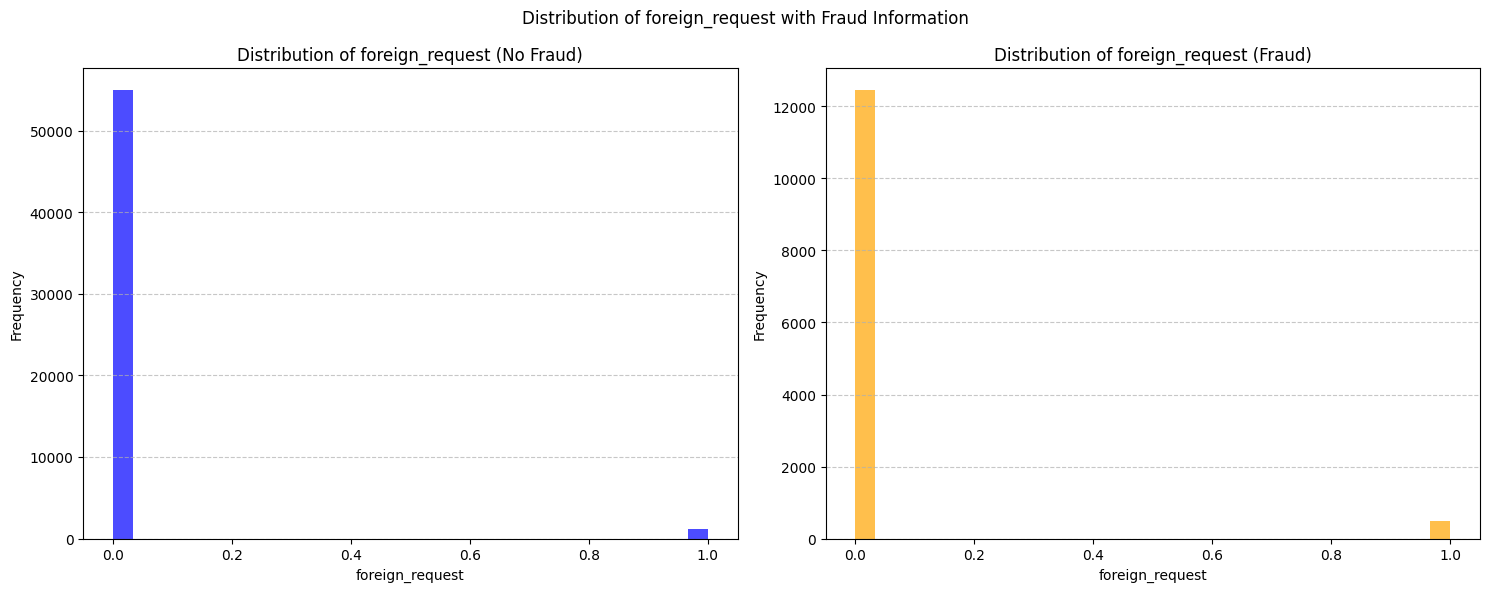

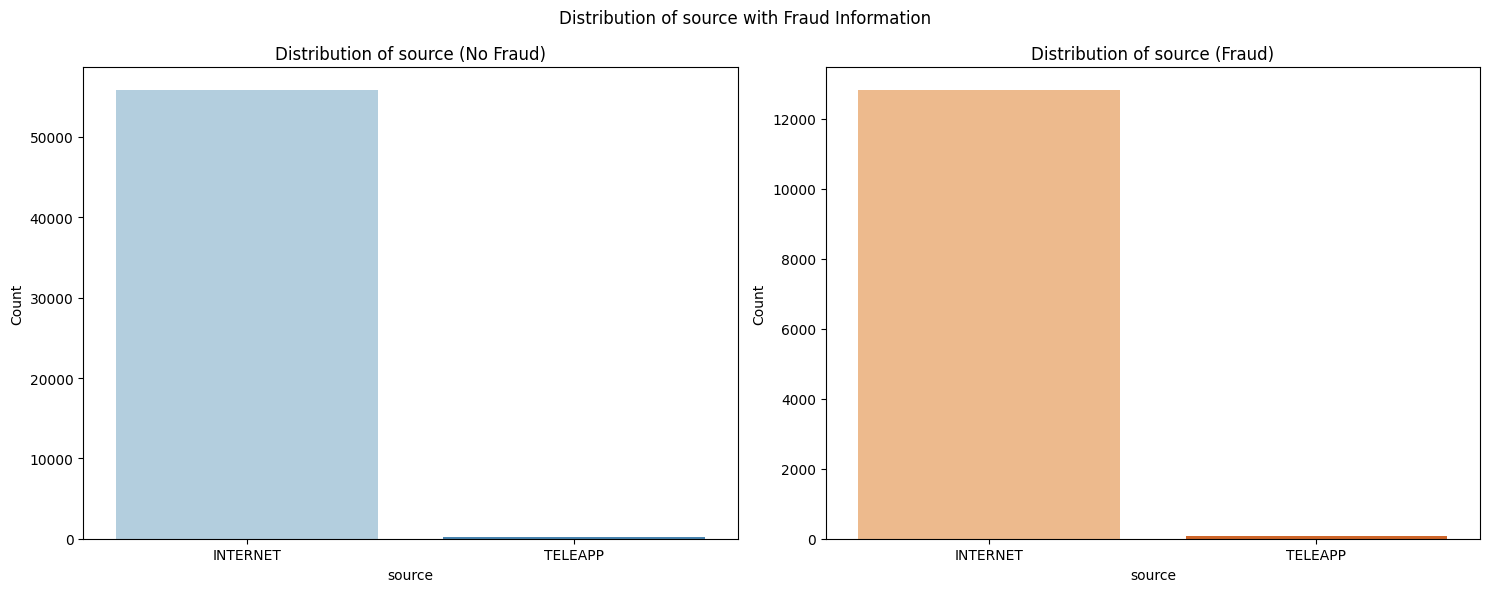

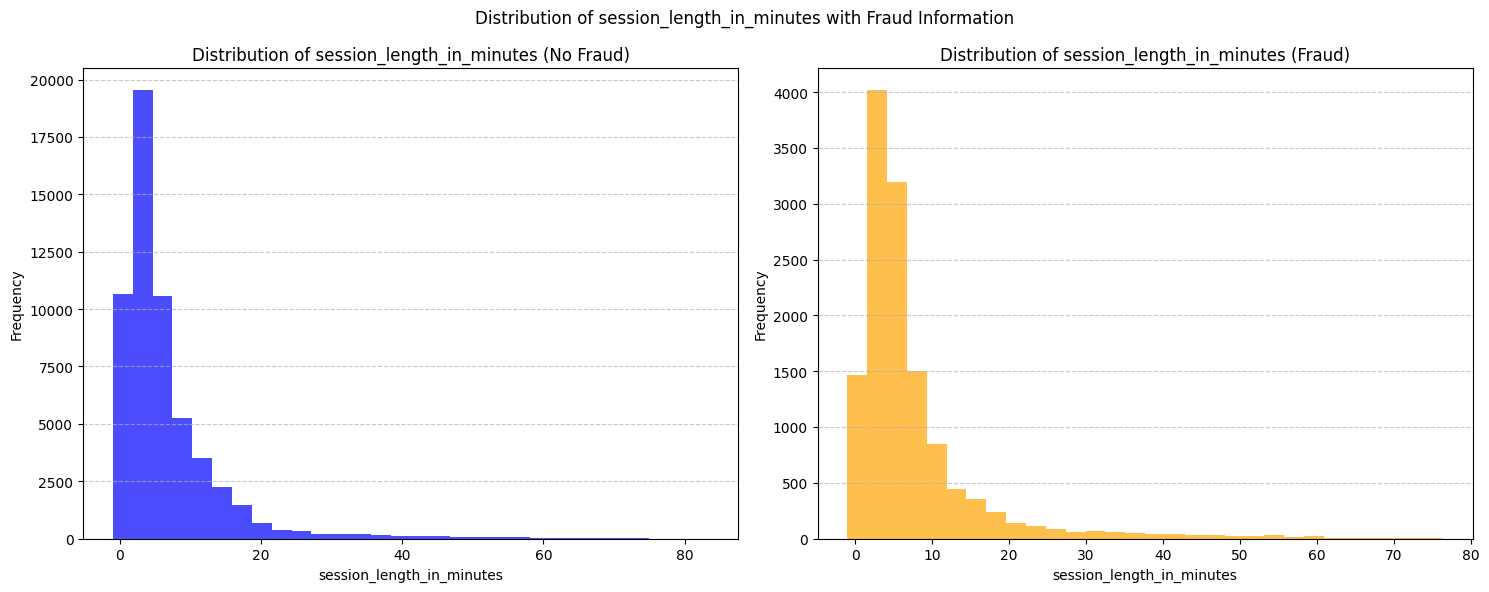

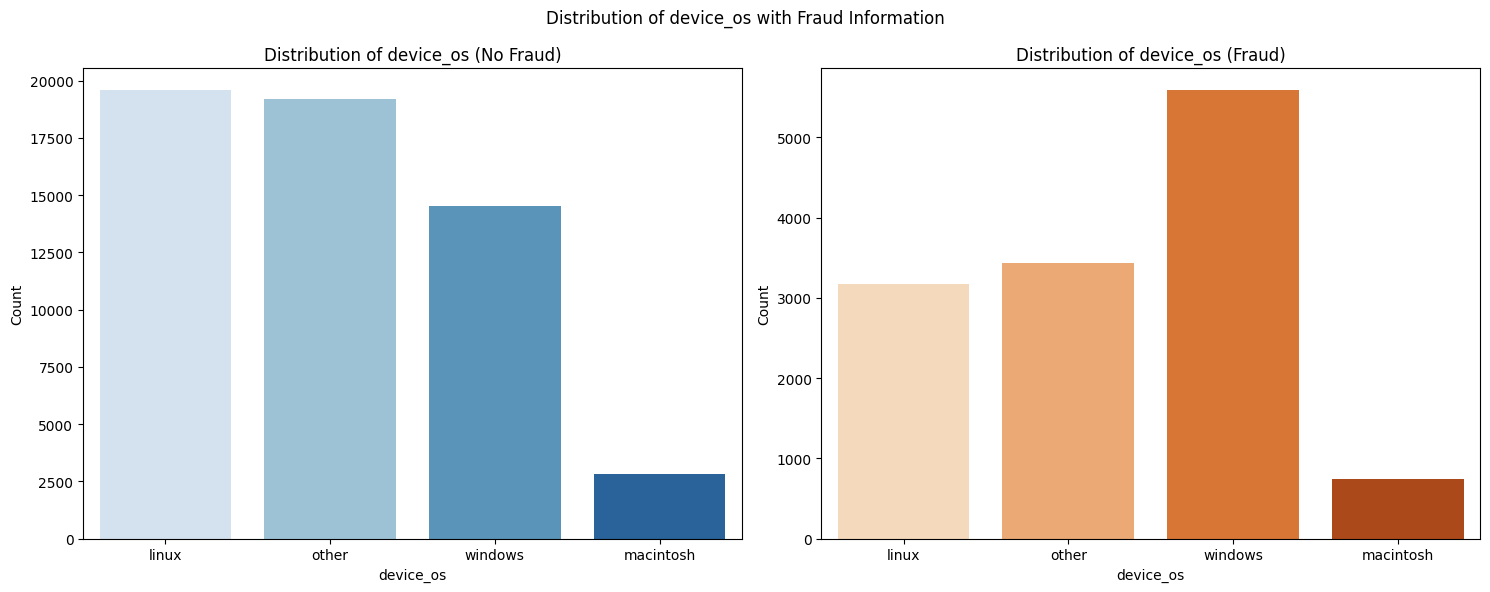

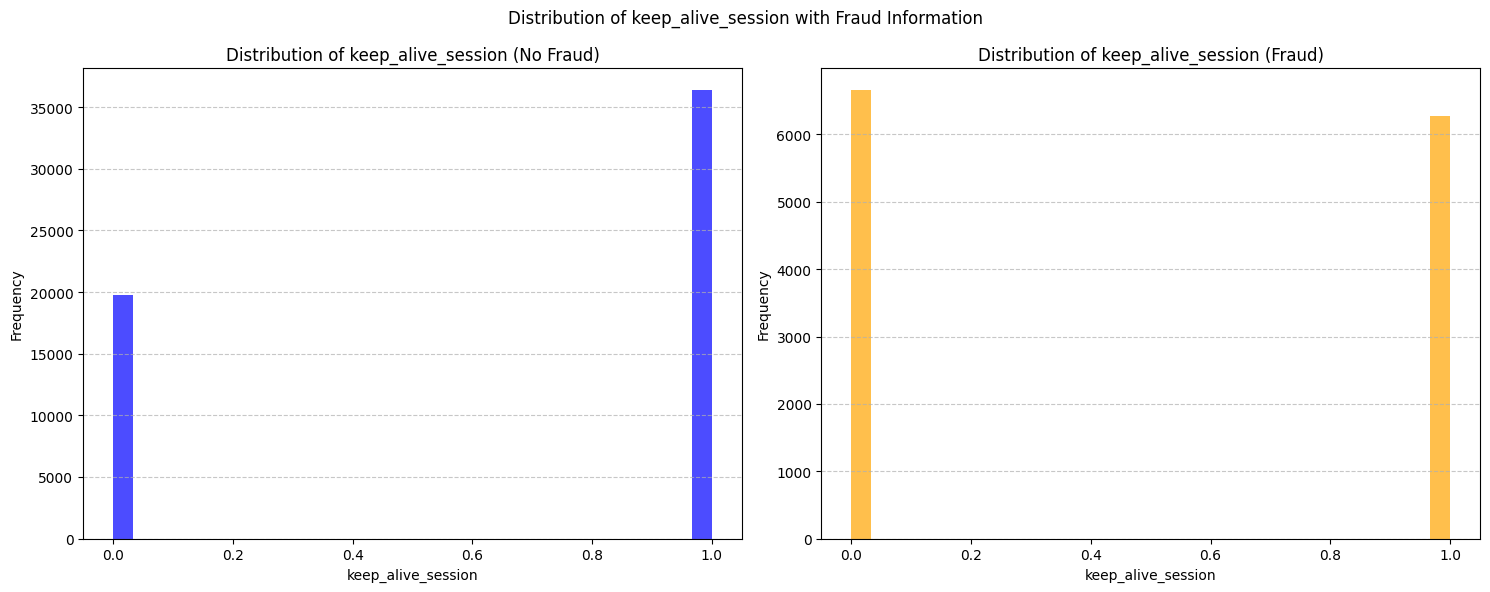

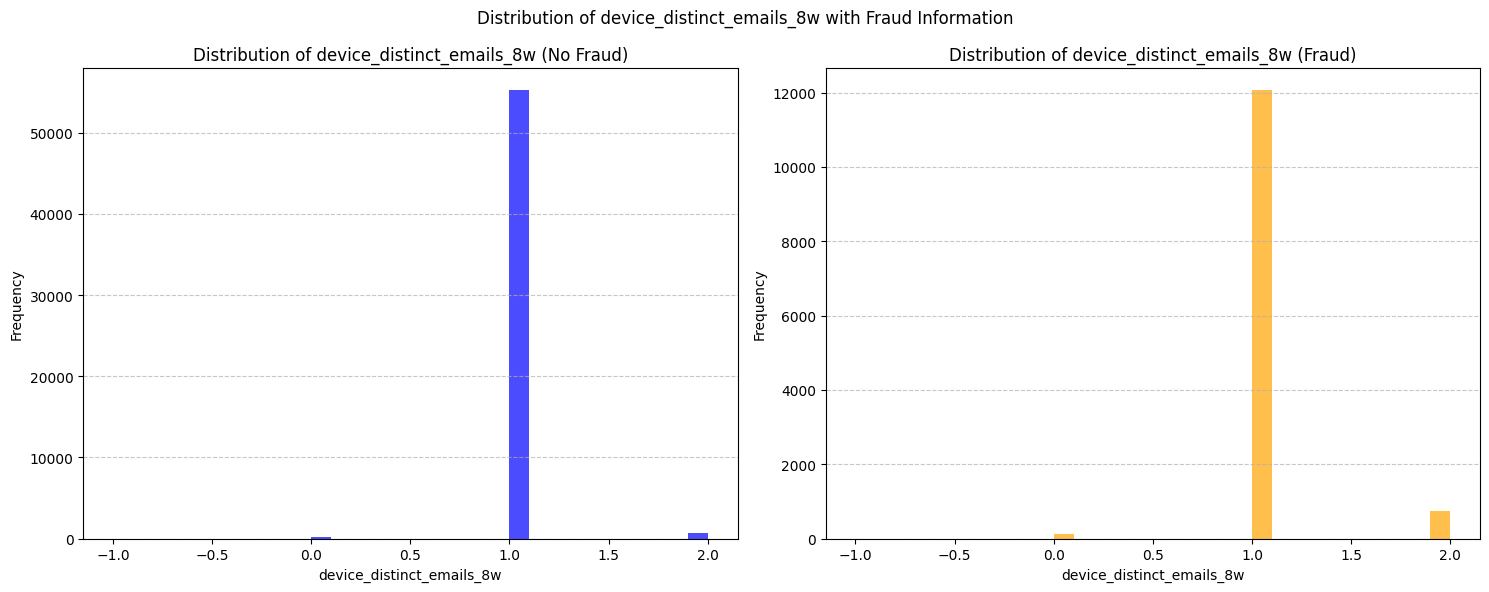

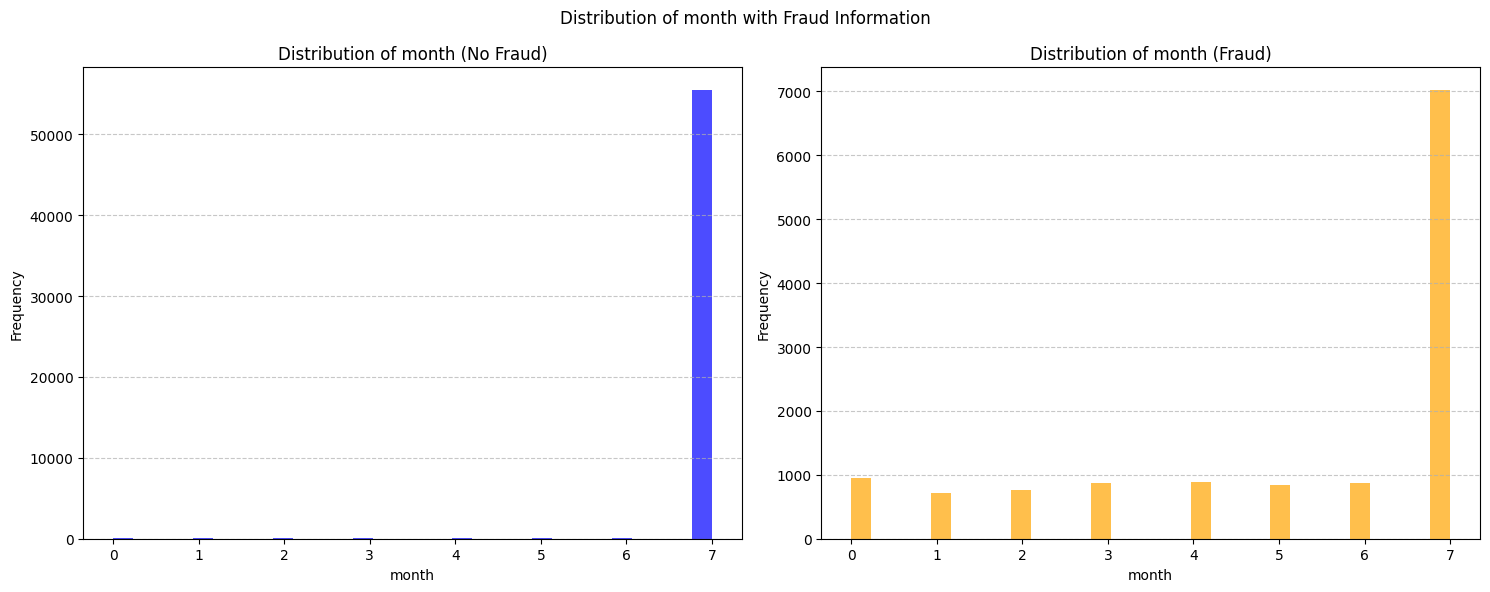

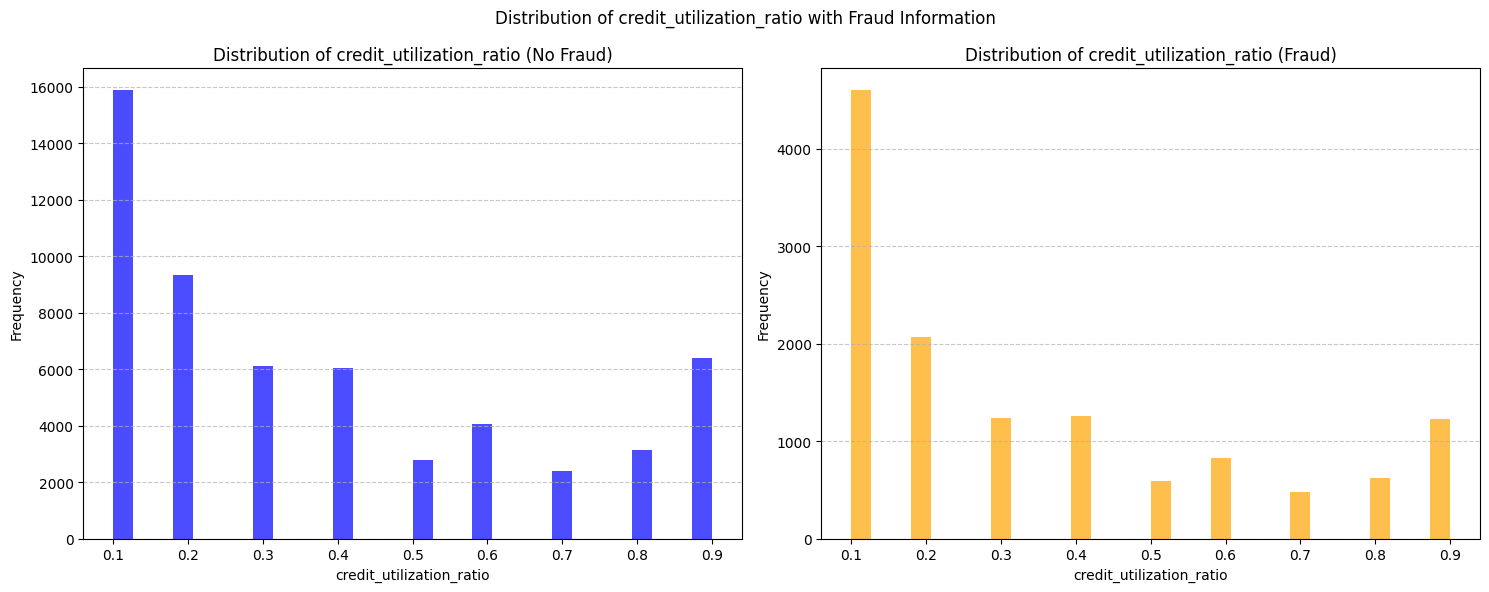

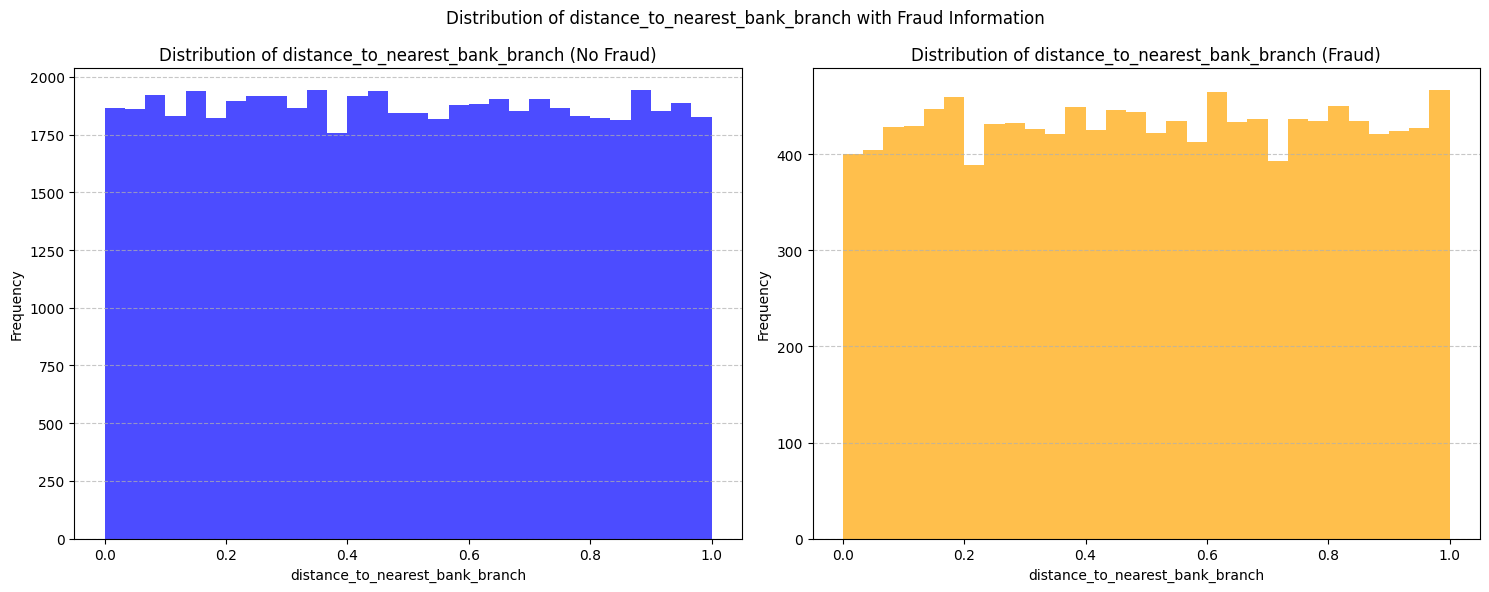

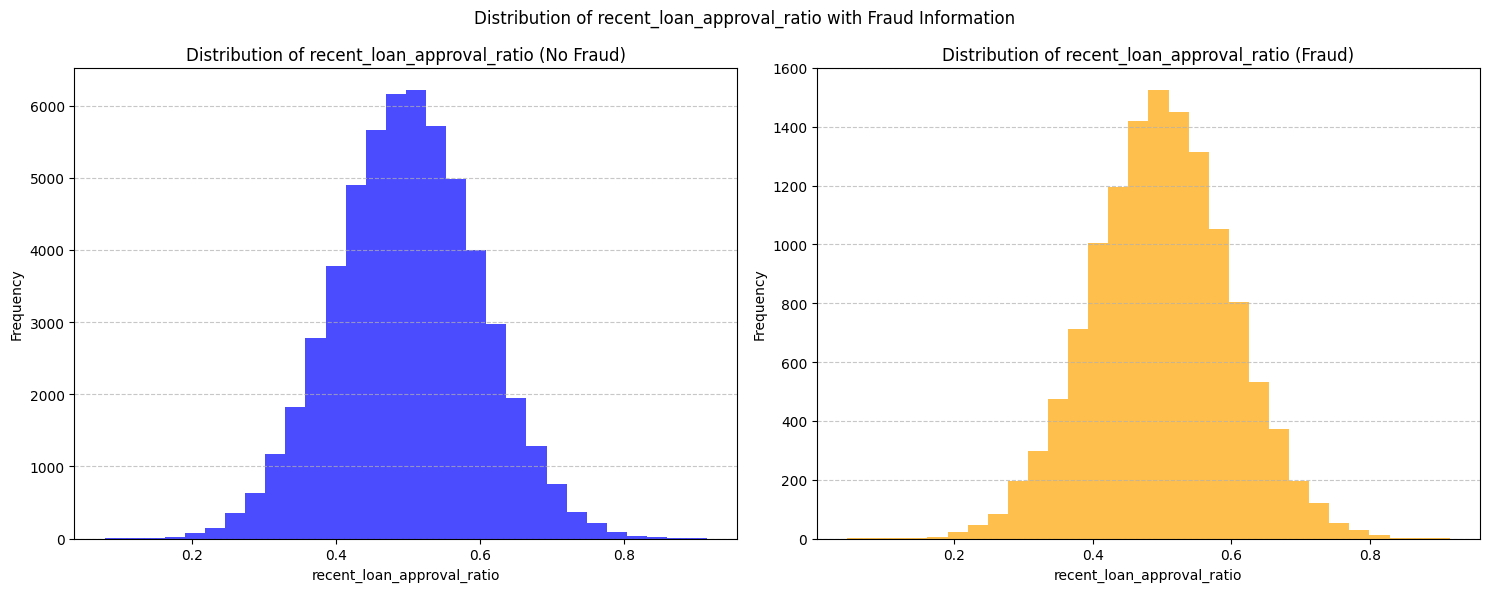

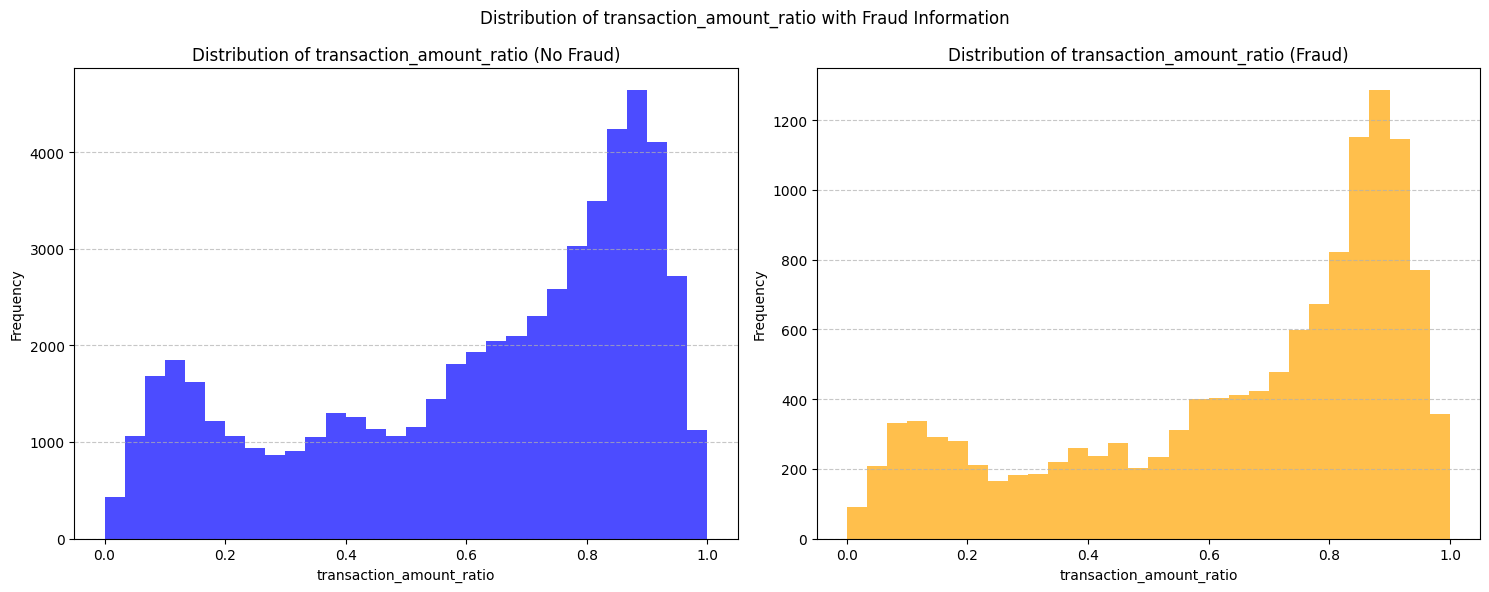

In [12]:

def plot_distributions_with_fraud(df, fraud_column, features_to_plot, output_directory='./plots'):
    if fraud_column not in df.columns:
        raise ValueError(f"A coluna '{fraud_column}' não está presente no DataFrame.")

    os.makedirs(output_directory, exist_ok=True)
    
    for column in features_to_plot:
        plt.figure(figsize=(15, 6))
        
        if df[column].dtype == 'O':  
            categories_order = df[column].astype('category').value_counts().index
            plt.subplot(1, 2, 1)
            sns.countplot(data=df[df[fraud_column] == 0], x=column, order=categories_order, palette='Blues')
            plt.title(f'Distribution of {column} (No Fraud)')
            plt.xlabel(column)
            plt.ylabel('Count')
            
            plt.subplot(1, 2, 2)
            sns.countplot(data=df[df[fraud_column] == 1], x=column, order=categories_order, palette='Oranges')
            plt.title(f'Distribution of {column} (Fraud)')
            plt.xlabel(column)
            plt.ylabel('Count')
        else:  # Se a coluna é numérica
            plt.subplot(1, 2, 1)
            plt.hist(df[df[fraud_column] == 0][column], bins=30, color='blue', alpha=0.7)
            plt.title(f'Distribution of {column} (No Fraud)')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            plt.subplot(1, 2, 2)
            plt.hist(df[df[fraud_column] == 1][column], bins=30, color='orange', alpha=0.7)
            plt.title(f'Distribution of {column} (Fraud)')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.suptitle(f'Distribution of {column} with Fraud Information')
        plt.tight_layout()
        plt.savefig(f'{output_directory}/{column}_with_fraud.png')
        plt.show()

features_to_plot = df.select_dtypes(include='number').columns
features_to_plot = df.columns.drop('fraud_bool')
plot_distributions_with_fraud(df, 'fraud_bool', features_to_plot)

In [13]:
df['fraud_bool'].value_counts()/len(df)*100

0    81.281936
1    18.718064
Name: fraud_bool, dtype: float64

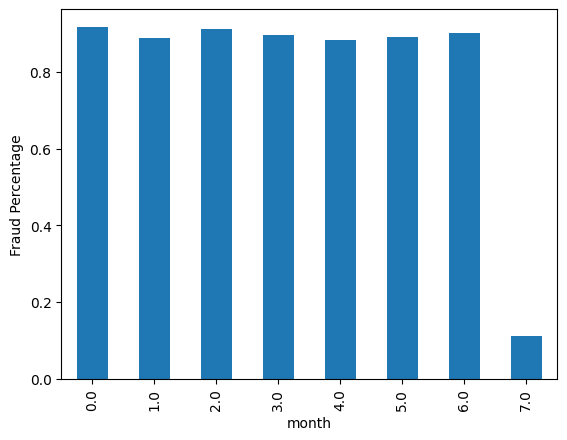

In [14]:
df.groupby('month')['fraud_bool'].mean().plot.bar()
plt.ylabel('Fraud Percentage')
plt.show()

In [15]:
# Percentagem de fraude em cada mes
df.groupby('month')['fraud_bool'].mean()*100

month
0.0    91.819057
1.0    88.820639
2.0    91.105769
3.0    89.762151
4.0    88.346614
5.0    89.266738
6.0    90.123457
7.0    11.237483
Name: fraud_bool, dtype: float64

## Conclusions

income - Multimodal distribution. Cannot extract any insights from this feature.

name_email_similarity - we can see that the histogram is multimodal. This means that there are multiple peaks in the data. In this case, we notice that there are 3 peaks. But in de fraud case, the left peak is higher than the other 2 peaks. This means that there are more fraud cases with low name_email_similarity, that can be explained by the fact that the fraudsters use fake emails.

current_address_month_count - Cannot extract any insights from this feature.

customer_age - follows a normal distribution. We can see that the bars between 40 and 60 are relatively higher than the bars on the non-fraud case. This means that there are more fraud cases with customers that have age between 40 and 60.

days_since_request - Cannot extract any insights from this feature.

intended_balcon_amount -  Cannot extract any insights from this feature.

payment_type - AB is the most common in both cases. Cannot extract any insights from this feature.

zip_count_4w - the distribution is identical in both cases. Around zip code 3000 there are more fraud cases than expected.

velocity_6h - the distribution is identical in both cases. Around 8000 there are more fraud cases than expected.

velocity_24h - the distribution is identical in both cases. Around 5000 and 6000 there are more fraud cases than expected.

velocity_4w - Cannot extract any insights from this feature.

bank_branch_count_8w - Cannot extract any insights from this feature.

date_of_birth_distinct_emails_4w - Cannot extract any insights from this feature.

employment_status - Cannot extract any insights from this feature.

credit_risk_score - Cannot extract any insights from this feature.

email_is_free - Cannot extract any insights from this feature.

housing_status - BC is more common in non-frauds BA is more common in frauds.

phone_home_valid - Cannot extract any insights from this feature.

phone_mobile_valid - Cannot extract any insights from this feature.

bank_months_count - Cannot extract any insights from this feature.

has_other_cards - Cannot extract any insights from this feature.

proposed_credit_limit - Cannot extract any insights from this feature.

foreign_request - Cannot extract any insights from this feature.

source - Cannot extract any insights from this feature.

session_length_in_minutes - Cannot extract any insights from this feature.

device_os - We see that the number of frauds is unexpectedly high for Windows.

keep_alive_session- Cannot extract any insights from this feature.

device_distinct_emails_8w - Cannot extract any insights from this feature.

month - In the fraud case, the percentage of frauds is extremely high in all months except for 7. Between 0 and 6 the percentage of fraud is near 90%.

credit_utilization_ratio - Cannot extract any insights from this feature.

distance_to_nearest_bank_branch - Cannot extract any insights from this feature.

recent_loan_approval_ratio - Cannot extract any insights from this feature.

transaction_amount_ratio - Cannot extract any insights from this feature.

# Correlations

                                    income  name_email_similarity  \
income                            1.000000              -0.029094   
name_email_similarity            -0.029094               1.000000   
current_address_months_count     -0.012548               0.046506   
customer_age                      0.142061              -0.052383   
days_since_request               -0.012244              -0.018270   
intended_balcon_amount            0.045672               0.027426   
zip_count_4w                     -0.035151              -0.009137   
velocity_6h                      -0.042401              -0.013139   
velocity_24h                     -0.033084              -0.008660   
velocity_4w                       0.004073              -0.038381   
bank_branch_count_8w              0.005150              -0.005843   
date_of_birth_distinct_emails_4w -0.056790               0.004716   
credit_risk_score                 0.154957               0.053567   
email_is_free                    -

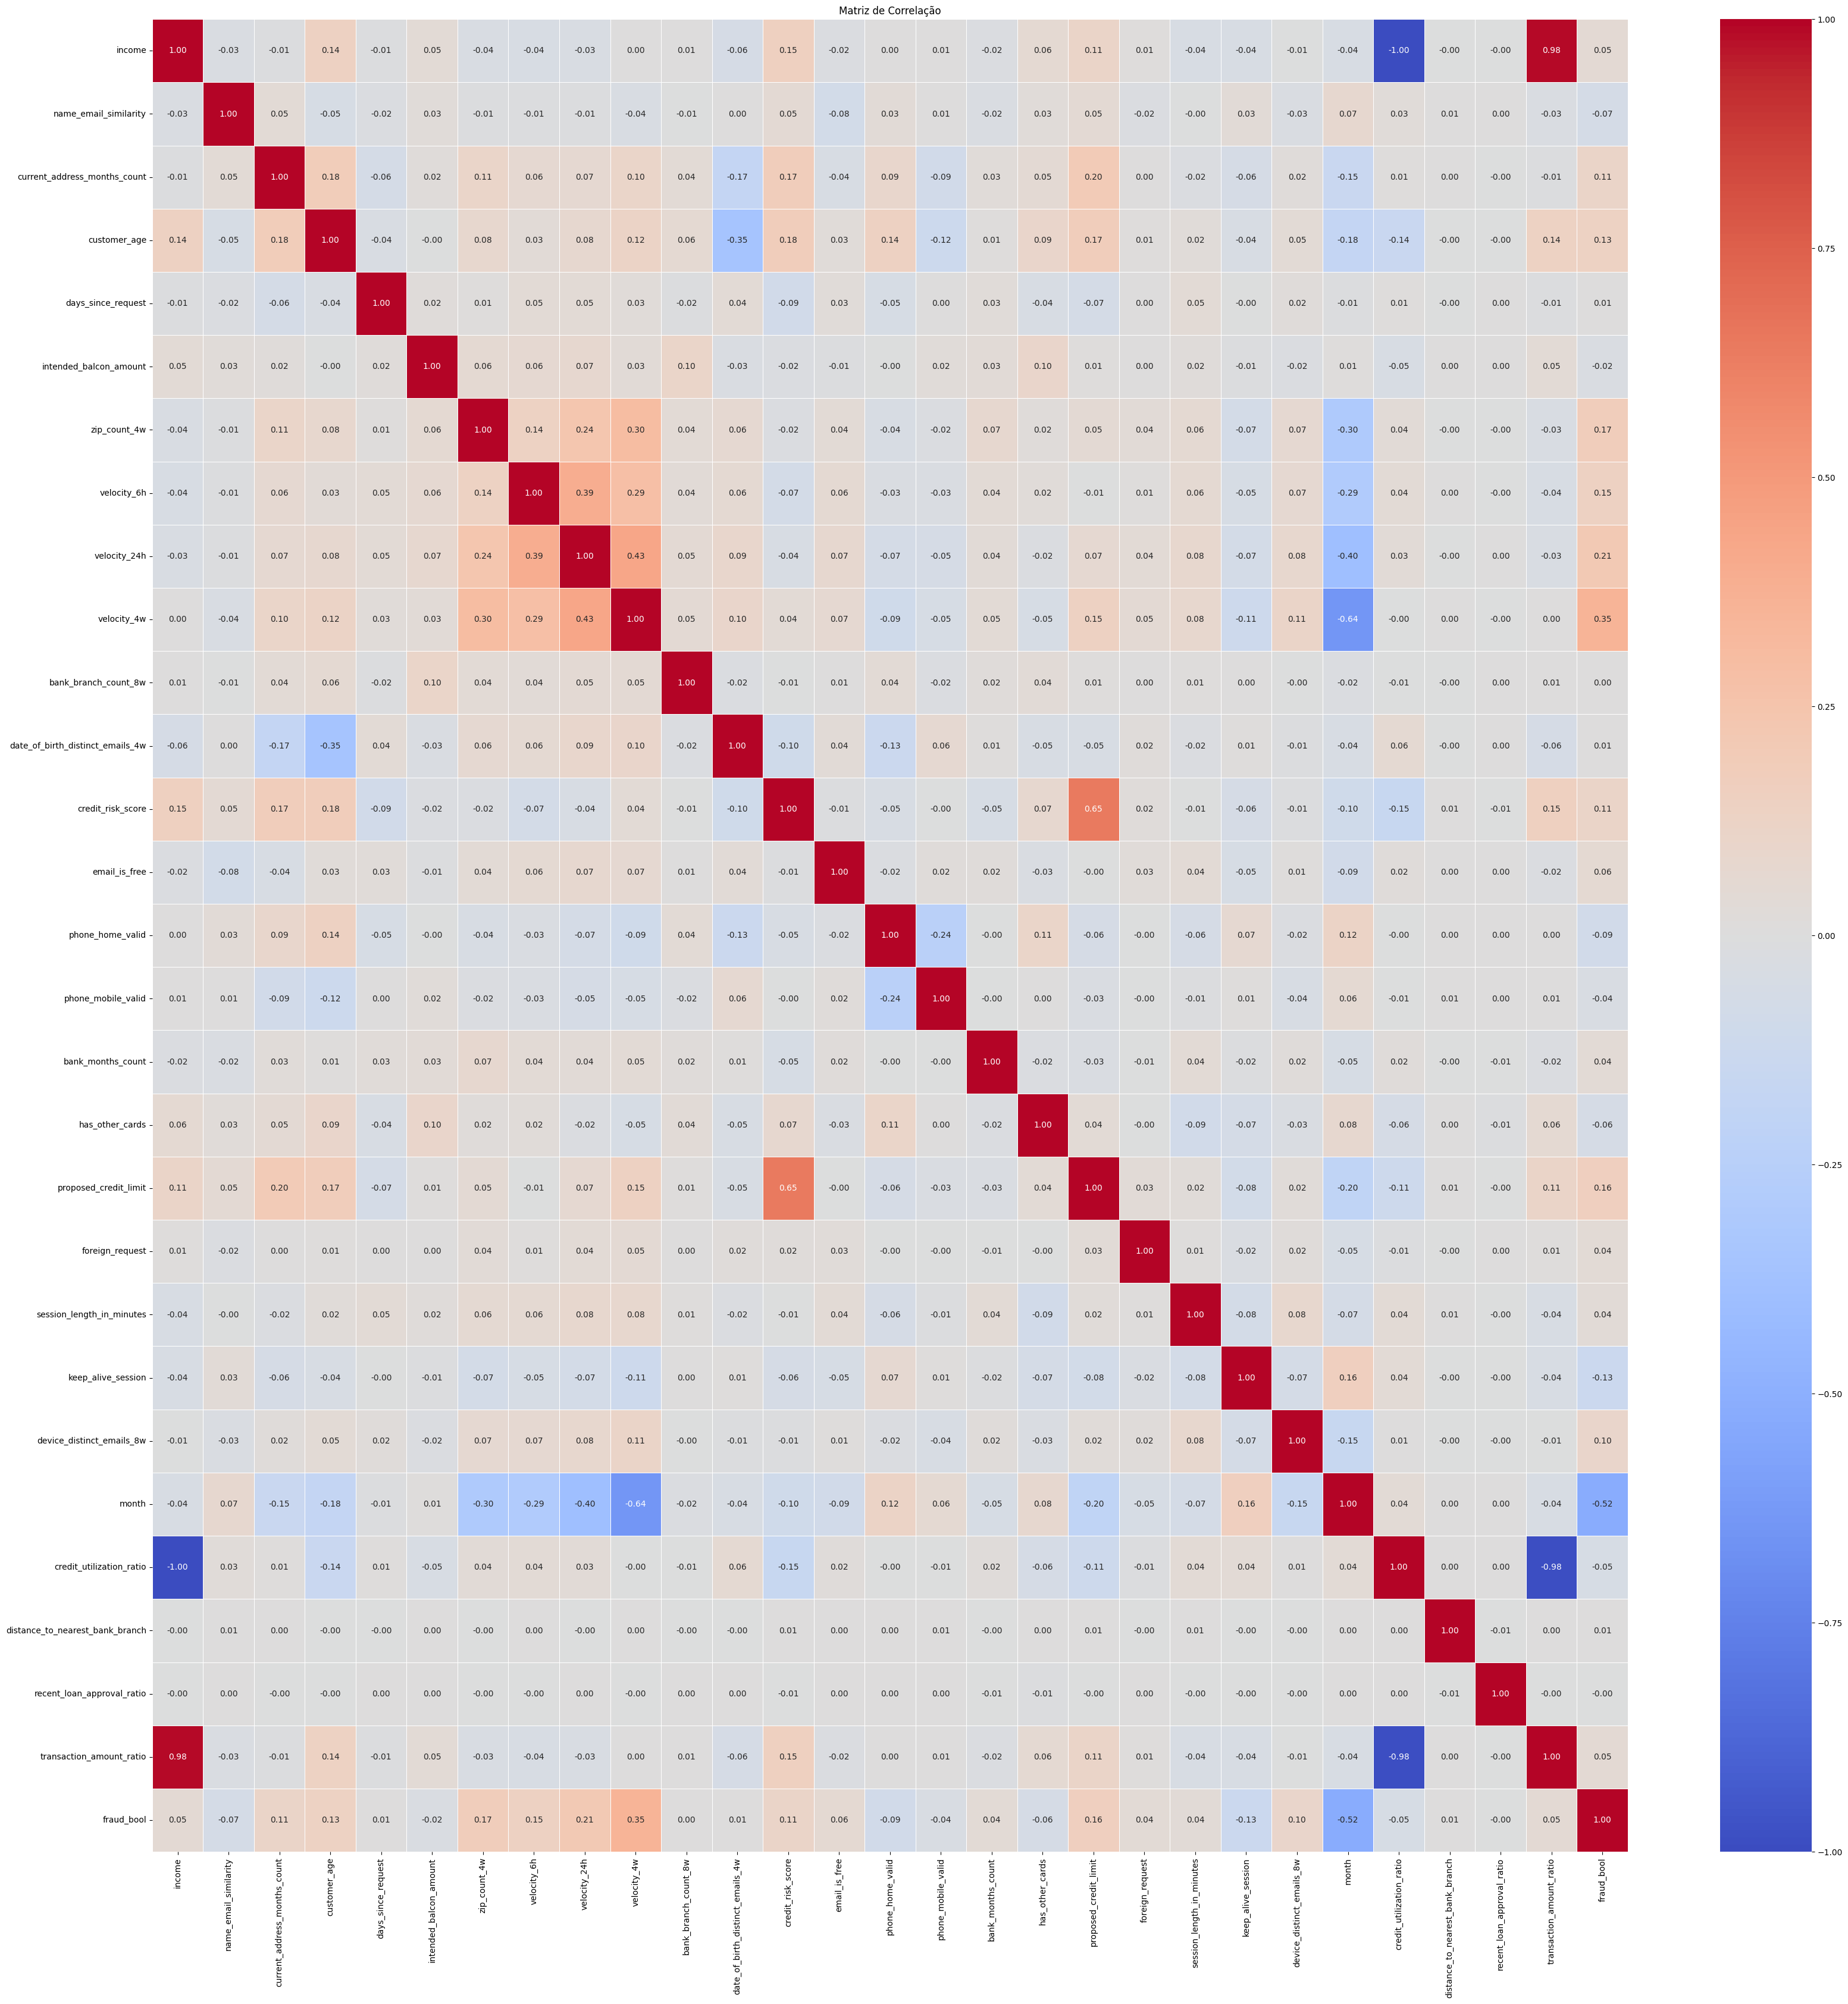

In [16]:
correlation_matrix = df.corr()
print(correlation_matrix)
plt.figure(figsize=(40, 40))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlação')
#Save the plot
plt.savefig('correlation_matrix.png')
plt.show()

In [17]:
df['income_credit_limit_ratio'] = df['income'] / df['proposed_credit_limit']
df['income_credit_limit_ratio'].describe()

count    69083.000000
mean         0.002164
std          0.001554
min          0.000050
25%          0.000600
50%          0.001800
75%          0.004000
max          0.004500
Name: income_credit_limit_ratio, dtype: float64

In [18]:
df['velocity_ratio_6h_24h'] = df['velocity_6h'] / df['velocity_24h']
df['velocity_ratio_6h_24h'].describe()

count    69083.000000
mean         1.159918
std          0.616137
min         -0.024413
25%          0.722428
50%          1.129576
75%          1.502255
max          8.195380
Name: velocity_ratio_6h_24h, dtype: float64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69083 entries, 0 to 69999
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   income                            69083 non-null  float64
 1   name_email_similarity             69083 non-null  float64
 2   current_address_months_count      69083 non-null  float64
 3   customer_age                      69083 non-null  float64
 4   days_since_request                69083 non-null  float64
 5   intended_balcon_amount            69083 non-null  float64
 6   payment_type                      69025 non-null  object 
 7   zip_count_4w                      69083 non-null  float64
 8   velocity_6h                       69083 non-null  float64
 9   velocity_24h                      69083 non-null  float64
 10  velocity_4w                       69083 non-null  float64
 11  bank_branch_count_8w              69083 non-null  float64
 12  date

# Preprocessing

Now that we have cleaned the data, we can start preprocessing it. We will be doing the following steps:
1. We will be checking the data types of each column.
2. We will be checking the distribution of each column.
3. We will be checking the correlation between the columns.
4. We will be checking the distribution of the target variable.
5. We will be checking the correlation between the target variable and the other columns.
6. We will be checking the distribution of the target variable for each column.5r4

In [20]:
columns_to_encode = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
encoders = {column: OneHotEncoder(sparse_output=False, handle_unknown='ignore') for column in columns_to_encode}

for column, encoder in encoders.items():
    encoded_data = encoder.fit_transform(df[column].values.reshape(-1, 1))
    encoded_columns = [f"{column}_{i}" for i in range(encoded_data.shape[1])]
    df[encoded_columns] = pd.DataFrame(encoded_data, columns=encoded_columns)

df.drop(columns=columns_to_encode, inplace=True)
df = df.fillna(0)      

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69083 entries, 0 to 69999
Data columns (total 59 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   income                            69083 non-null  float64
 1   name_email_similarity             69083 non-null  float64
 2   current_address_months_count      69083 non-null  float64
 3   customer_age                      69083 non-null  float64
 4   days_since_request                69083 non-null  float64
 5   intended_balcon_amount            69083 non-null  float64
 6   zip_count_4w                      69083 non-null  float64
 7   velocity_6h                       69083 non-null  float64
 8   velocity_24h                      69083 non-null  float64
 9   velocity_4w                       69083 non-null  float64
 10  bank_branch_count_8w              69083 non-null  float64
 11  date_of_birth_distinct_emails_4w  69083 non-null  float64
 12  cred

# Feature Selection

In [22]:
# Separar features e target
X = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']

# Inicializar o modelo de Random Forest
rf_model = RandomForestClassifier()

# Treinar o modelo
rf_model.fit(X, y)

# Exibir importância das features
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

                             Feature  Importance
23                             month    0.211930
9                        velocity_4w    0.075460
8                       velocity_24h    0.055076
7                        velocity_6h    0.039610
6                       zip_count_4w    0.038799
2       current_address_months_count    0.038370
1              name_email_similarity    0.036350
12                 credit_risk_score    0.034655
4                 days_since_request    0.034242
5             intended_balcon_amount    0.034043
20         session_length_in_minutes    0.033900
25   distance_to_nearest_bank_branch    0.033886
26        recent_loan_approval_ratio    0.033715
29             velocity_ratio_6h_24h    0.033233
27          transaction_amount_ratio    0.032747
10              bank_branch_count_8w    0.024085
11  date_of_birth_distinct_emails_4w    0.022980
3                       customer_age    0.017151
28         income_credit_limit_ratio    0.017038
16                 b

In [23]:
# Inicializar o modelo de Regressão Logística
model = LogisticRegression()

# Inicializar o seletor RFE
rfe = RFE(model, n_features_to_select=5)  # Escolha o número desejado de features

# Fit do RFE
rfe.fit(X, y)

# Exibir as features selecionadas
selected_features = X.columns[rfe.support_]
print(selected_features)

Index(['name_email_similarity', 'foreign_request', 'keep_alive_session',
       'month', 'credit_utilization_ratio'],
      dtype='object')


# Train and Test Splitting

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Modelo Support Vector Machine (SVM)
model_svm = SVC()
model_svm.fit(X_train, y_train)
predictions_svm = model_svm.predict(X_test)

# Avaliação do modelo SVM
svm_accuracy = accuracy_score(y_test, predictions_svm)
svm_classification_report = classification_report(y_test, predictions_svm)
svm_confusion_matrix = confusion_matrix(y_test, predictions_svm)

# Modelo de Regressão Logística
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)

# Avaliação do modelo de Regressão Logística
lr_accuracy = accuracy_score(y_test, predictions_lr)
lr_classification_report = classification_report(y_test, predictions_lr)
lr_confusion_matrix = confusion_matrix(y_test, predictions_lr)

# Modelo k-Nearest Neighbors (k-NN)
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
predictions_knn = model_knn.predict(X_test)

# Avaliação do modelo k-NN
knn_accuracy = accuracy_score(y_test, predictions_knn)
knn_classification_report = classification_report(y_test, predictions_knn)
knn_confusion_matrix = confusion_matrix(y_test, predictions_knn)

# Modelo Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
predictions_nb = model_nb.predict(X_test)

# Avaliação do modelo Naive Bayes
nb_accuracy = accuracy_score(y_test, predictions_nb)
nb_classification_report = classification_report(y_test, predictions_nb)
nb_confusion_matrix = confusion_matrix(y_test, predictions_nb)

# Modelo Árvore de Decisão
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
predictions_dt = model_dt.predict(X_test)

# Avaliação do modelo Árvore de Decisão
dt_accuracy = accuracy_score(y_test, predictions_dt)
dt_classification_report = classification_report(y_test, predictions_dt)
dt_confusion_matrix = confusion_matrix(y_test, predictions_dt)

# Modelo de Rede Neural
model_nn = MLPClassifier()
model_nn.fit(X_train, y_train)
predictions_nn = model_nn.predict(X_test)

# Avaliação do modelo de Rede Neural
nn_accuracy = accuracy_score(y_test, predictions_nn)
nn_classification_report = classification_report(y_test, predictions_nn)
nn_confusion_matrix = confusion_matrix(y_test, predictions_nn)

# Imprimir resultados para o modelo SVM
print("\nSVM Metrics:")
print(f"Accuracy: {svm_accuracy:.4f}")
print("Classification Report:")
print(svm_classification_report)
print("Confusion Matrix:")
print(svm_confusion_matrix)

# Imprimir resultados para o modelo de Regressão Logística
print("\nLogistic Regression Metrics:")
print(f"Accuracy: {lr_accuracy:.4f}")
print("Classification Report:")
print(lr_classification_report)
print("Confusion Matrix:")
print(lr_confusion_matrix)

# Imprimir resultados para o modelo k-NN
print("\nk-NN Metrics:")
print(f"Accuracy: {knn_accuracy:.4f}")
print("Classification Report:")
print(knn_classification_report)
print("Confusion Matrix:")
print(knn_confusion_matrix)

# Imprimir resultados para o modelo Naive Bayes
print("\nNaive Bayes Metrics:")
print(f"Accuracy: {nb_accuracy:.4f}")
print("Classification Report:")
print(nb_classification_report)
print("Confusion Matrix:")
print(nb_confusion_matrix)

# Imprimir resultados para o modelo Árvore de Decisão
print("\nDecision Tree Metrics:")
print(f"Accuracy: {dt_accuracy:.4f}")
print("Classification Report:")
print(dt_classification_report)
print("Confusion Matrix:")
print(dt_confusion_matrix)

# Imprimir resultados para o modelo de Rede Neural
print("\nNeural Network Metrics:")
print(f"Accuracy: {nn_accuracy:.4f}")
print("Classification Report:")
print(nn_classification_report)
print("Confusion Matrix:")
print(nn_confusion_matrix)


SVM Metrics:
Accuracy: 0.8398
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     11222
           1       0.72      0.24      0.36      2595

    accuracy                           0.84     13817
   macro avg       0.78      0.61      0.63     13817
weighted avg       0.82      0.84      0.81     13817

Confusion Matrix:
[[10981   241]
 [ 1973   622]]

Logistic Regression Metrics:
Accuracy: 0.8131
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     11222
           1       0.53      0.05      0.09      2595

    accuracy                           0.81     13817
   macro avg       0.67      0.52      0.49     13817
weighted avg       0.76      0.81      0.74     13817

Confusion Matrix:
[[11110   112]
 [ 2470   125]]

k-NN Metrics:
Accuracy: 0.8250
Classification Report:
              precision    recall  f1-score   support

           0  